In [1]:
import matplotlib
matplotlib.use('MACOSX')

In [1]:
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import pathlib
from utils.angle import angle_mod
import matplotlib as mpl


from CubicSpline import cubic_spline_planner

# === Parameters =====

# LQR parameter
lqr_Q = np.eye(5)
lqr_R = np.eye(2)
dt = 0.1  # time tick[s]
L = 0.5  # Wheel base of the vehicle [m]
max_steer = np.deg2rad(45.0)  # maximum steering angle[rad]

show_animation = True


class State:

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v

class SteeringControl:

    def __init__(self):
        self.ax = None
        self.ay = None
        self.goal = None
        

def update(state, a, delta):

    if delta >= max_steer:
        delta = max_steer
    if delta <= - max_steer:
        delta = - max_steer

    state.x = state.x + state.v * math.cos(state.yaw) * dt
    state.y = state.y + state.v * math.sin(state.yaw) * dt
    state.yaw = state.yaw + state.v / L * math.tan(delta) * dt
    state.v = state.v + a * dt

    return state


def pi_2_pi(angle):
    return angle_mod(angle)

def solve_dare(A, B, Q, R):
    """
    solve a discrete time_Algebraic Riccati equation (DARE)
    """
    x = Q
    x_next = Q
    max_iter = 150
    eps = 0.01

    for i in range(max_iter):
        x_next = A.T @ x @ A - A.T @ x @ B @ \
                 la.inv(R + B.T @ x @ B) @ B.T @ x @ A + Q
        if (abs(x_next - x)).max() < eps:
            break
        x = x_next

    return x_next


def dlqr(A, B, Q, R):
    """Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    # ref Bertsekas, p.151
    """

    # first, try to solve the ricatti equation
    X = solve_dare(A, B, Q, R)

    # compute the LQR gain
    K = la.inv(B.T @ X @ B + R) @ (B.T @ X @ A)

    eig_result = la.eig(A - B @ K)

    return K, X, eig_result[0]


def lqr_speed_steering_control(state, cx, cy, cyaw, ck, pe, pth_e, sp, Q, R):
    ind, e = calc_nearest_index(state, cx, cy, cyaw)

    tv = sp[ind]

    k = ck[ind]
    v = state.v
    th_e = pi_2_pi(state.yaw - cyaw[ind])

    # A = [1.0, dt, 0.0, 0.0, 0.0
    #      0.0, 0.0, v, 0.0, 0.0]
    #      0.0, 0.0, 1.0, dt, 0.0]
    #      0.0, 0.0, 0.0, 0.0, 0.0]
    #      0.0, 0.0, 0.0, 0.0, 1.0]
    A = np.zeros((5, 5))
    A[0, 0] = 1.0
    A[0, 1] = dt
    A[1, 2] = v
    A[2, 2] = 1.0
    A[2, 3] = dt
    A[4, 4] = 1.0

    # B = [0.0, 0.0
    #     0.0, 0.0
    #     0.0, 0.0
    #     v/L, 0.0
    #     0.0, dt]
    B = np.zeros((5, 2))
    B[3, 0] = v / L
    B[4, 1] = dt

    K, _, _ = dlqr(A, B, Q, R)

    # state vector
    # x = [e, dot_e, th_e, dot_th_e, delta_v]
    # e: lateral distance to the path
    # dot_e: derivative of e
    # th_e: angle difference to the path
    # dot_th_e: derivative of th_e
    # delta_v: difference between current speed and target speed
    x = np.zeros((5, 1))
    x[0, 0] = e
    x[1, 0] = (e - pe) / dt
    x[2, 0] = th_e
    x[3, 0] = (th_e - pth_e) / dt
    x[4, 0] = v - tv

    # input vector
    # u = [delta, accel]
    # delta: steering angle
    # accel: acceleration
    ustar = -K @ x

    # calc steering input
    ff = math.atan2(L * k, 1)  # feedforward steering angle
    fb = pi_2_pi(ustar[0, 0])  # feedback steering angle
    delta = ff + fb

    # calc accel input
    accel = ustar[1, 0]

    return delta, ind, e, th_e, accel


def calc_nearest_index(state, cx, cy, cyaw):
    dx = [state.x - icx for icx in cx]
    dy = [state.y - icy for icy in cy]

    d = [idx ** 2 + idy ** 2 for (idx, idy) in zip(dx, dy)]

    mind = min(d)

    ind = d.index(mind)

    mind = math.sqrt(mind)

    dxl = cx[ind] - state.x
    dyl = cy[ind] - state.y

    angle = pi_2_pi(cyaw[ind] - math.atan2(dyl, dxl))
    if angle < 0:
        mind *= -1

    return ind, mind


def do_simulation(cx, cy, cyaw, ck, speed_profile, goal):
    T = 500.0  # max simulation time
    goal_dis = 0.3
    stop_speed = 0.05

    state = State(x=-0.0, y=-0.0, yaw=0.0, v=0.0)

    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]

    e, e_th = 0.0, 0.0

    while T >= time:
        dl, target_ind, e, e_th, ai = lqr_speed_steering_control(
            state, cx, cy, cyaw, ck, e, e_th, speed_profile, lqr_Q, lqr_R)

        state = update(state, ai, dl)

        if abs(state.v) <= stop_speed:
            target_ind += 1

        time = time + dt

        # check goal
        dx = state.x - goal[0]
        dy = state.y - goal[1]
        if math.hypot(dx, dy) <= goal_dis:
            print("Goal")
            break

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)

        if target_ind % 1 == 0 and show_animation:
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect('key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(cx, cy, "-r", label="course")
            plt.plot(x, y, "ob", label="trajectory")
            plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("speed[km/h]:" + str(round(state.v * 3.6, 2))
                      + ",target index:" + str(target_ind))
            plt.pause(0.0001)

    return t, x, y, yaw, v


def calc_speed_profile(cyaw, target_speed):
    speed_profile = [target_speed] * len(cyaw)

    direction = 1.0

    # Set stop point
    for i in range(len(cyaw) - 1):
        dyaw = abs(cyaw[i + 1] - cyaw[i])
        switch = math.pi / 4.0 <= dyaw < math.pi / 2.0

        if switch:
            direction *= -1

        if direction != 1.0:
            speed_profile[i] = - target_speed
        else:
            speed_profile[i] = target_speed

        if switch:
            speed_profile[i] = 0.0

    # speed down
    for i in range(int(len(cyaw)*0.25)):
        speed_profile[-i] = target_speed / (((len(cyaw)//2 + 10) - i) + 1)
        if speed_profile[-i] <= 1.0 / 3.6:
            speed_profile[-i] = 1.0 / 3.6

    return speed_profile


def main():
    print("LQR steering control tracking start!!")
    ax = [0.0, 6.0, 12.5, 10.0, 17.5, 20.0, 25.0]
    ay = [0.0, -3.0, -5.0, 6.5, 3.0, 0.0, 0.0]
    goal = [ax[-1], ay[-1]]

    cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=0.1)
    target_speed = 10.0 / 3.6  # simulation parameter km/h -> m/s

    sp = calc_speed_profile(cyaw, target_speed)

    t, x, y, yaw, v = do_simulation(cx, cy, cyaw, ck, sp, goal)

    if show_animation:  # pragma: no cover
        plt.close()
        plt.subplots(1)
        plt.plot(ax, ay, "xb", label="waypoints")
        plt.plot(cx, cy, "-r", label="target course")
        plt.plot(x, y, "-g", label="tracking")
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.legend()

        plt.subplots(1)
        plt.plot(s, [np.rad2deg(iyaw) for iyaw in cyaw], "-r", label="yaw")
        plt.grid(True)
        plt.legend()
        plt.xlabel("line length[m]")
        plt.ylabel("yaw angle[deg]")

        plt.subplots(1)
        plt.plot(s, ck, "-r", label="curvature")
        plt.grid(True)
        plt.legend()
        plt.xlabel("line length[m]")
        plt.ylabel("curvature [1/m]")

        plt.show()


In [2]:
def time_step(curr_state, e, e_th):
    dl, target_ind, e, e_th, ai = lqr_speed_steering_control(
    curr_state, cx, cy, cyaw, ck, e, e_th, sp, lqr_Q, lqr_R)

    state = update(curr_state, ai, dl)
    
    if abs(state.v) <= stop_speed:
        target_ind += 1
    
    # time = time + dt
    
    # check goal
    dx = state.x - goal[0]
    dy = state.y - goal[1]
    if math.hypot(dx, dy) <= goal_dis:
        print("Goal")
    
    x.append(state.x)
    y.append(state.y)
    yaw.append(state.yaw)
    v.append(state.v)
    t.append(time)
    
    
    plt.cla()
    # for stopping simulation with the esc key.
    plt.gcf().canvas.mpl_connect('key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
    plt.plot(cx, cy, "-r", label="course")
    plt.plot(x, y, "ob", label="trajectory")
    plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
    plt.axis("equal")
    plt.grid(True)
    plt.title("speed[km/h]:" + str(round(state.v * 3.6, 2))
              + ",target index:" + str(target_ind))
    plt.pause(0.0001)

    return state, e, e_th, ai, dl

In [8]:
# constants
goal_dis = 0.1
stop_speed = 0.05

# initial state
init_state = State(x=-0.0, y=-0.0, yaw=0.0, v=0.0)

# intial setup
time = 0.0
x = [init_state.x]
y = [init_state.y]
yaw = [init_state.yaw]
v = [init_state.v]
t = [0.0]
e, e_th = 0.0, 0.0

speed_target = 5 / 2.237 #mph to kmh by dividing by 2.237
ax = [0.0, 2.0, -2.0, 0]
ay = [0.0, 5.0, 10.0, 15.0]
goal = [ax[-1], ay[-1]]
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(ax, ay, ds=0.1)
sp = calc_speed_profile(cyaw, speed_target)

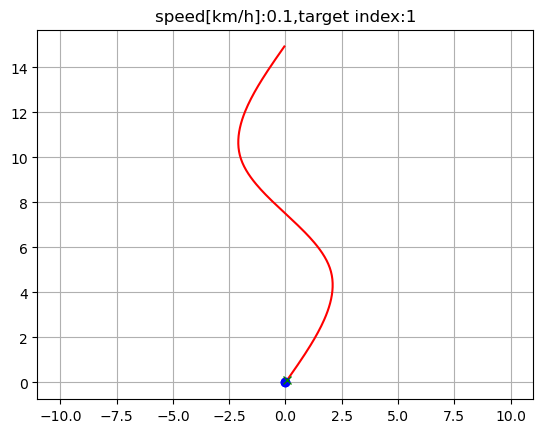

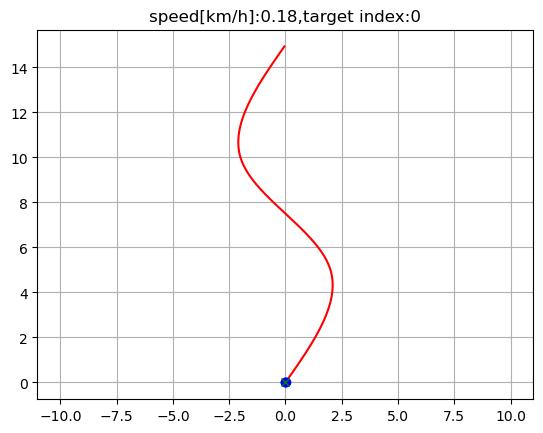

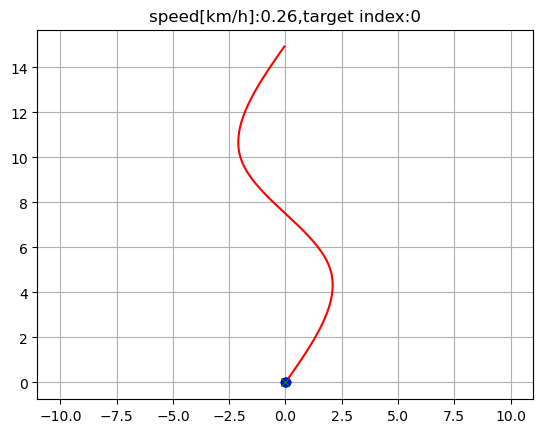

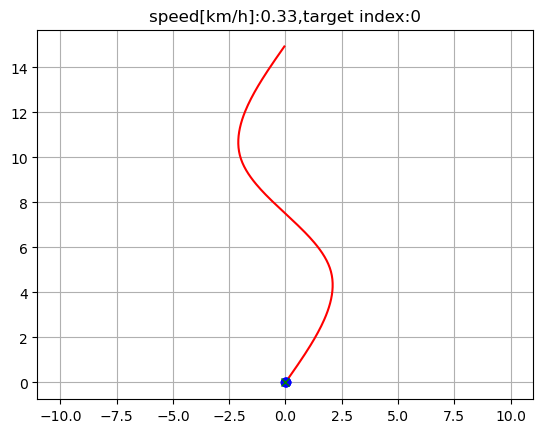

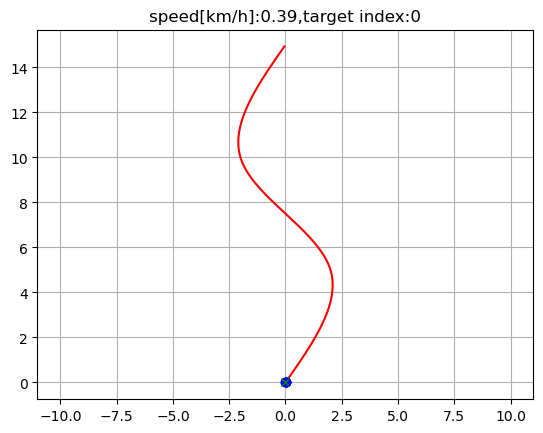

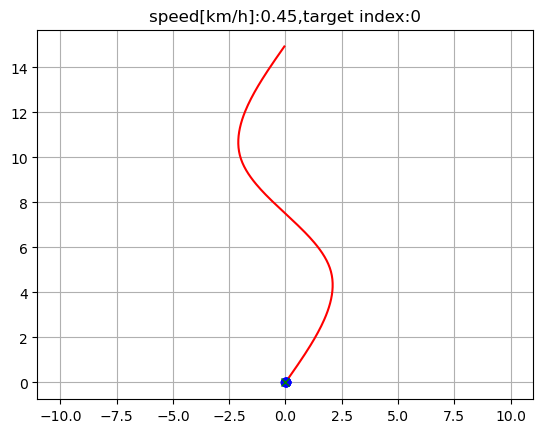

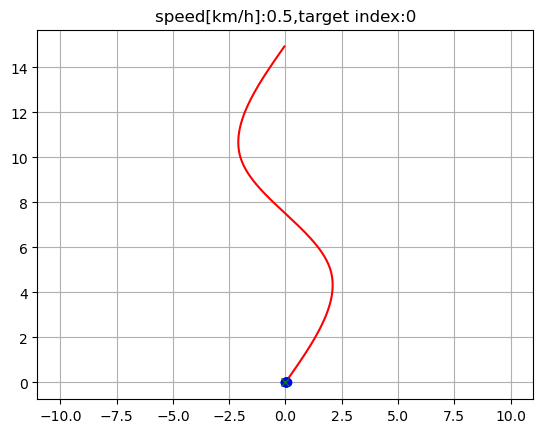

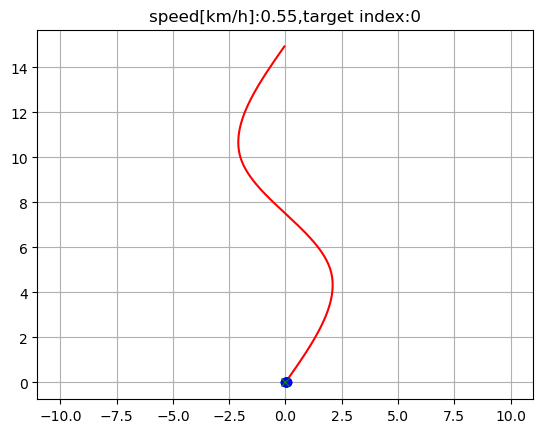

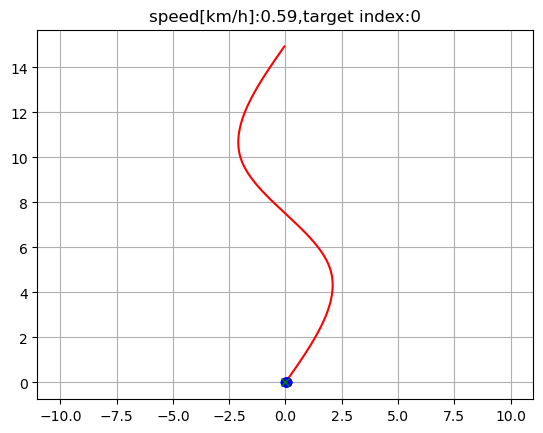

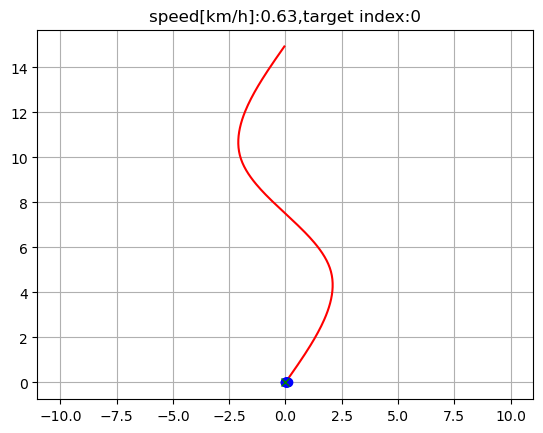

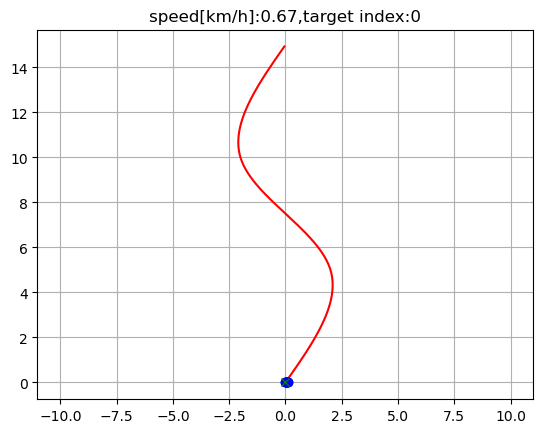

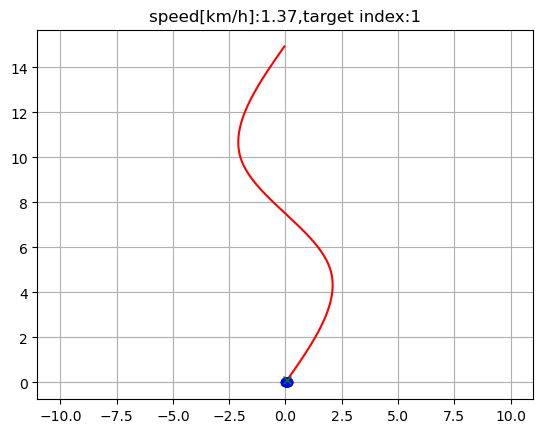

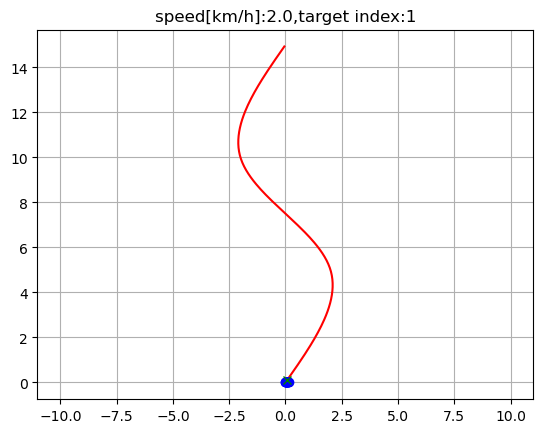

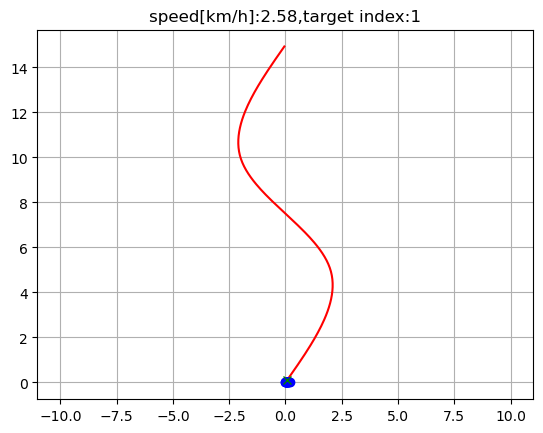

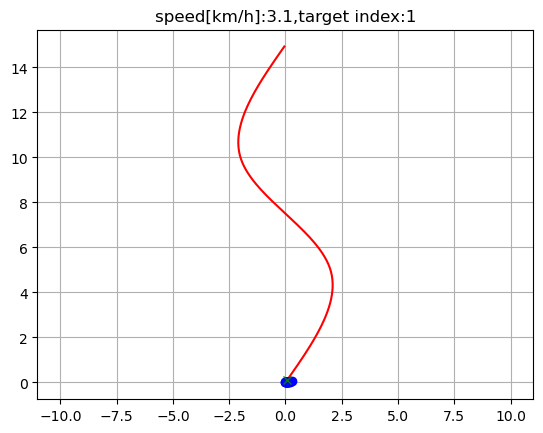

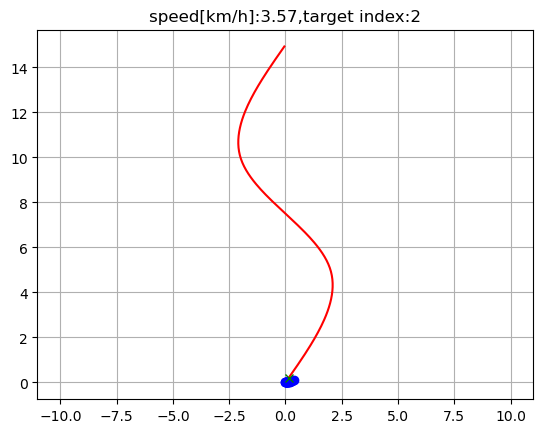

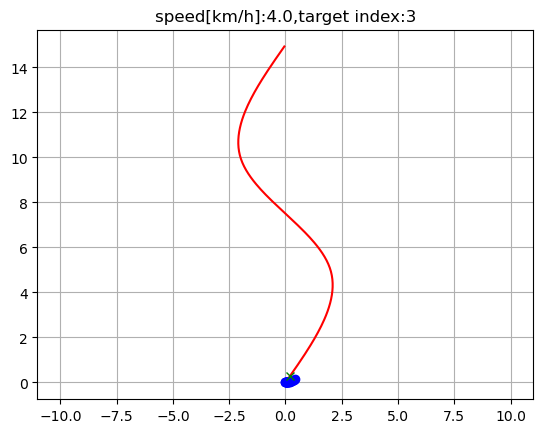

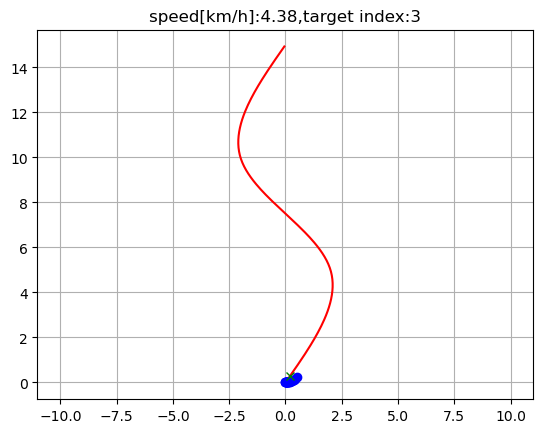

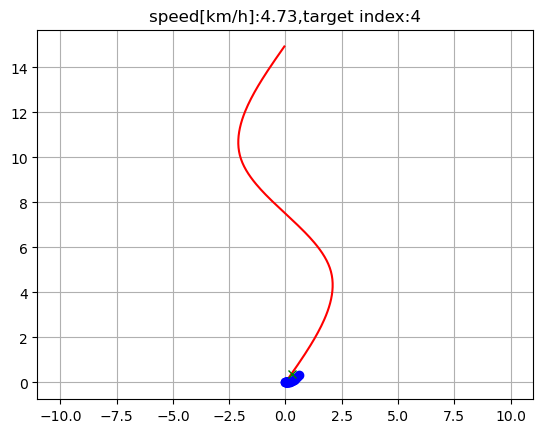

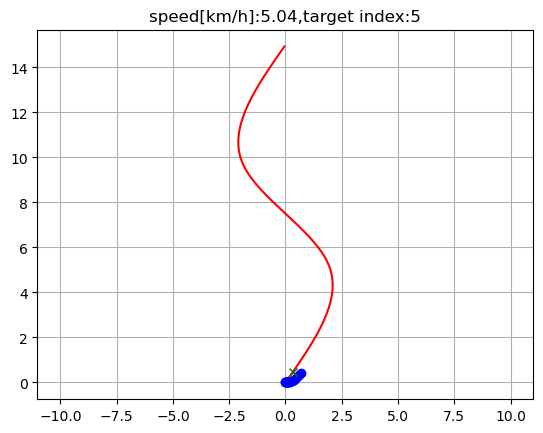

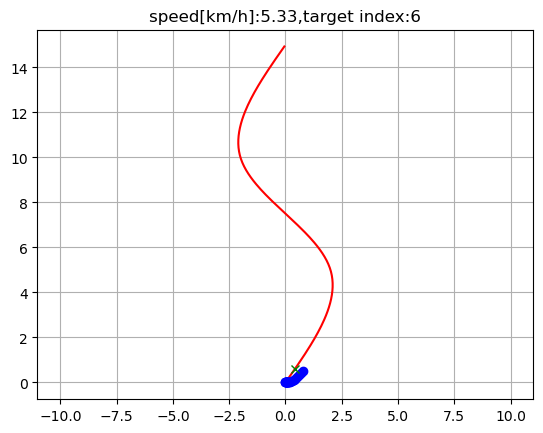

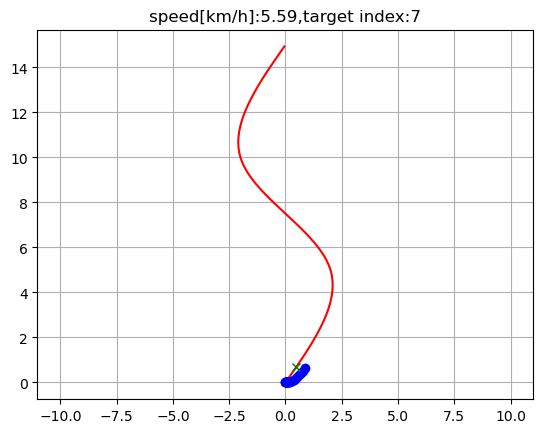

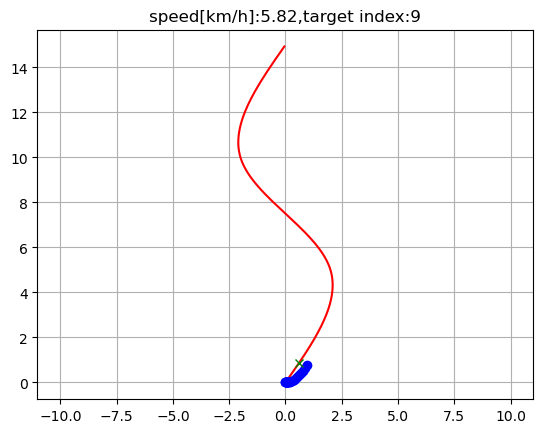

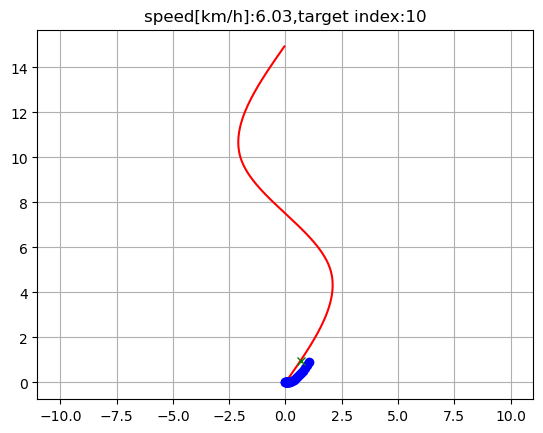

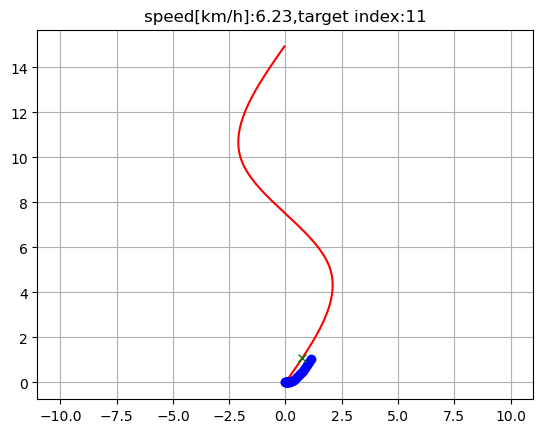

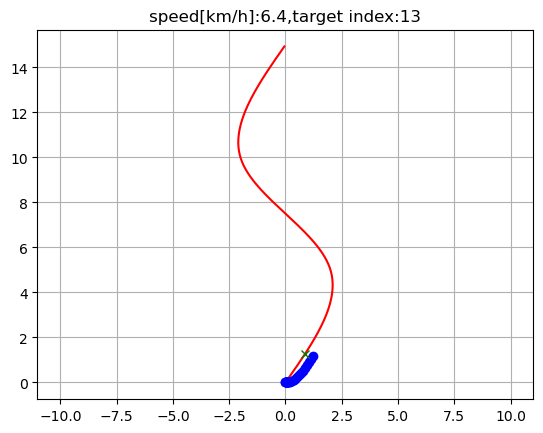

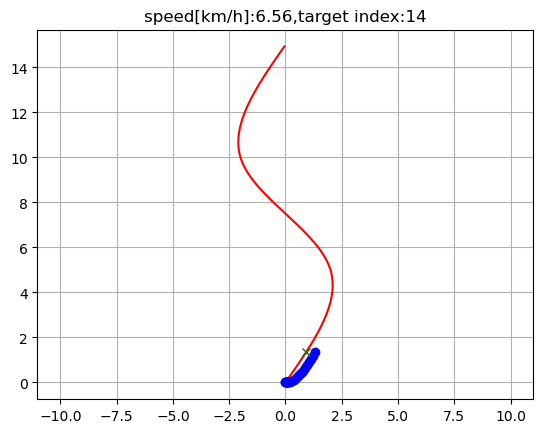

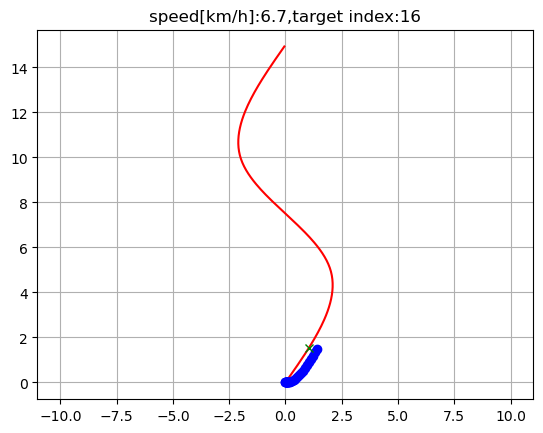

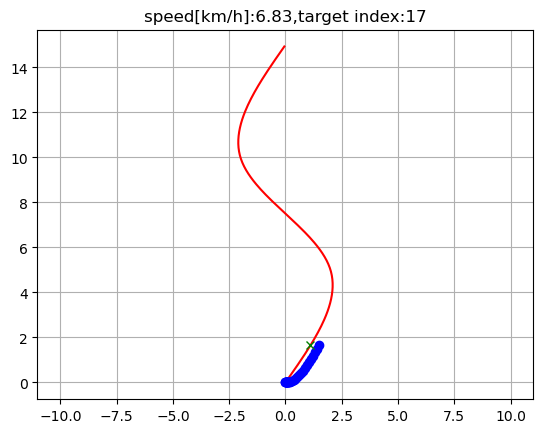

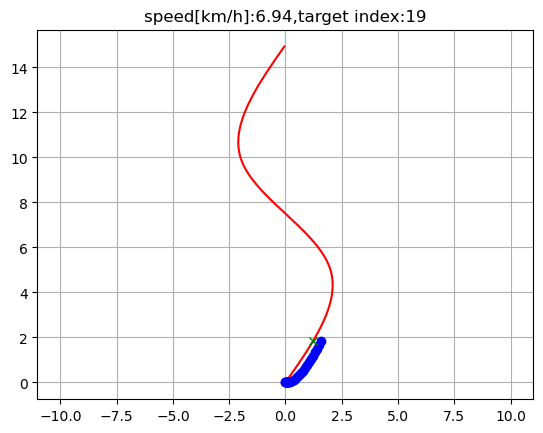

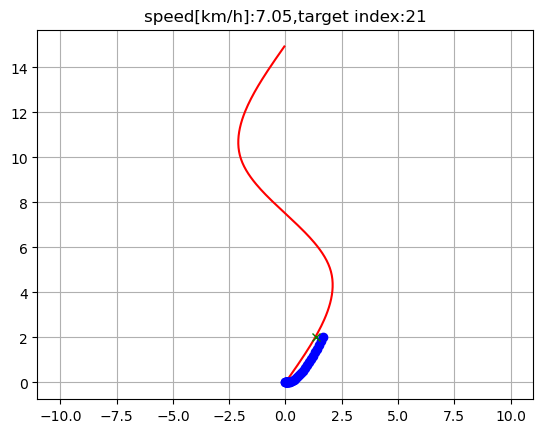

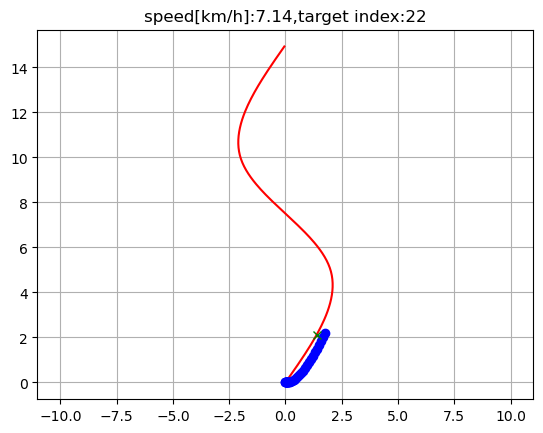

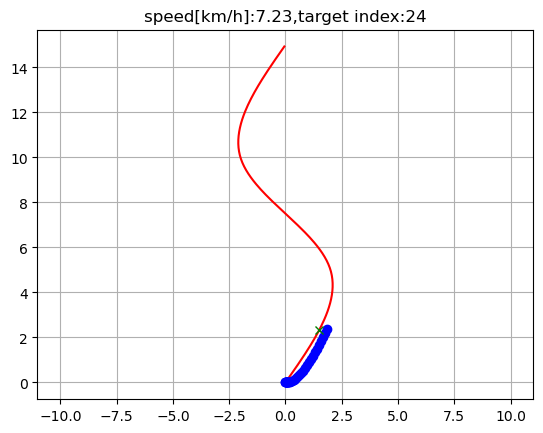

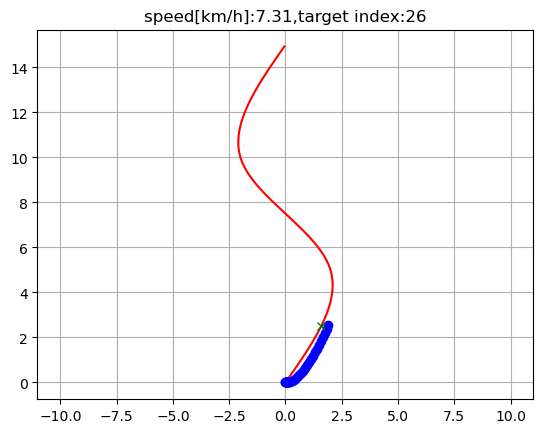

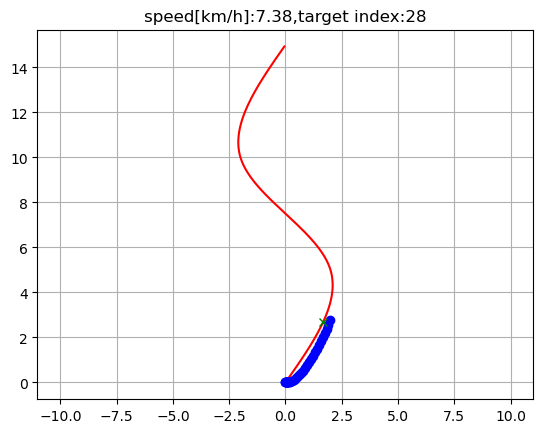

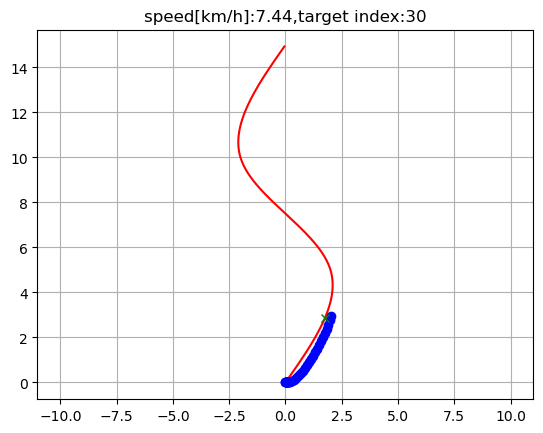

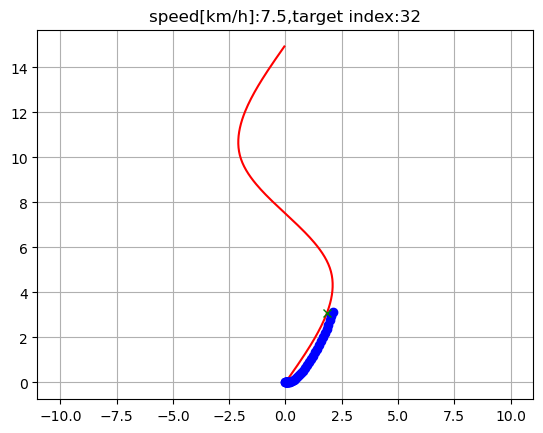

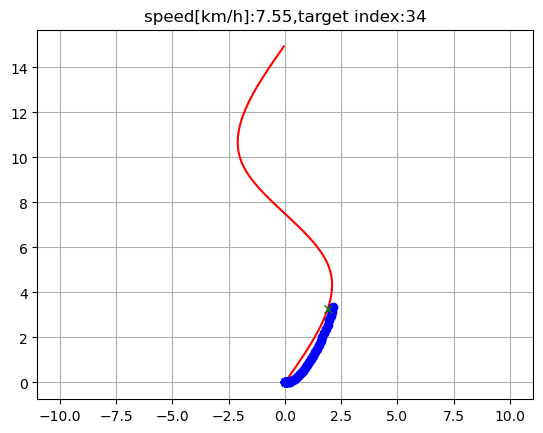

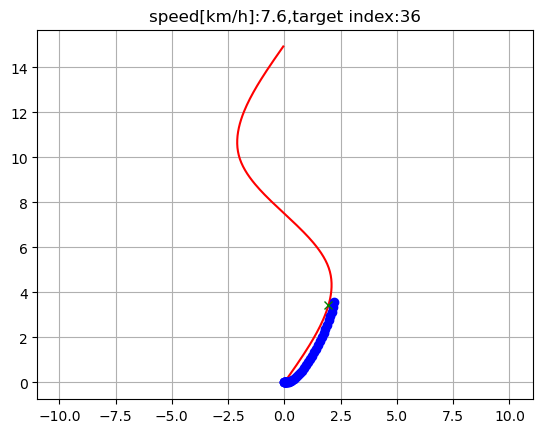

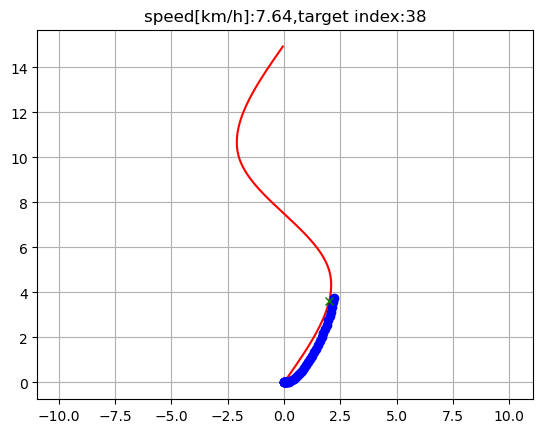

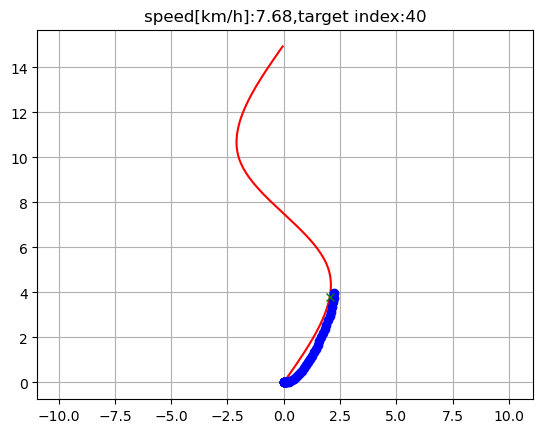

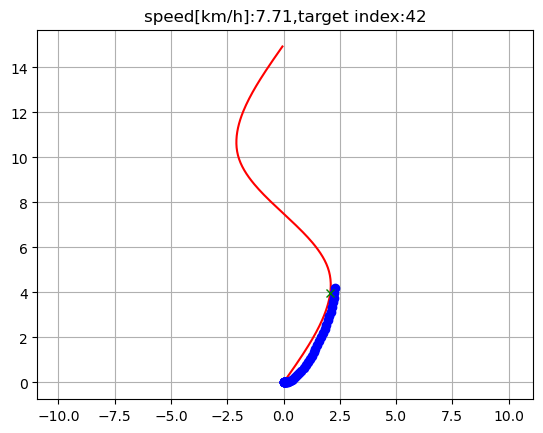

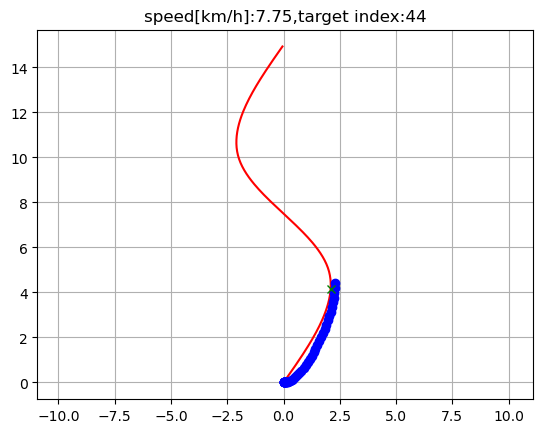

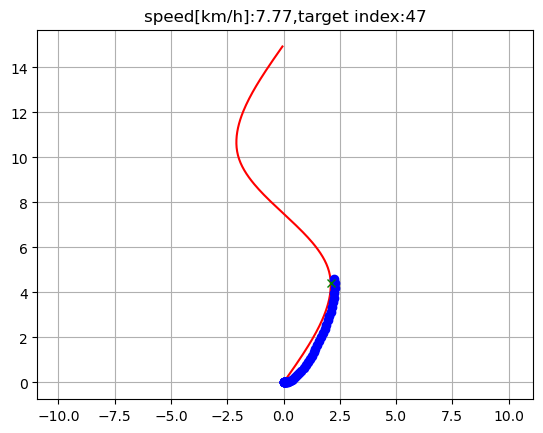

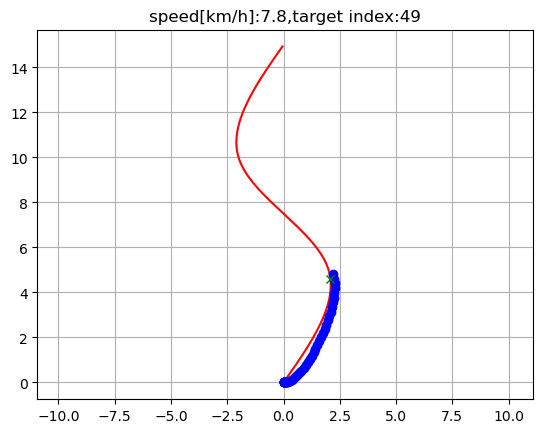

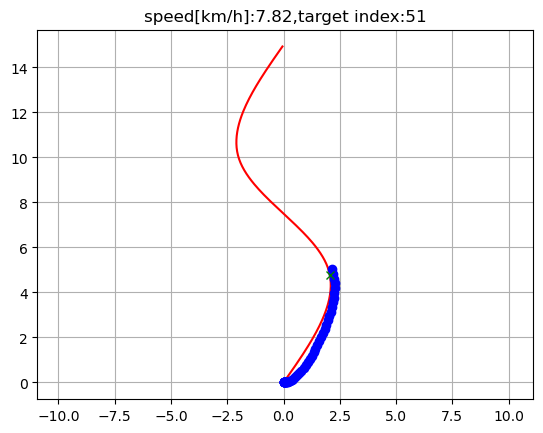

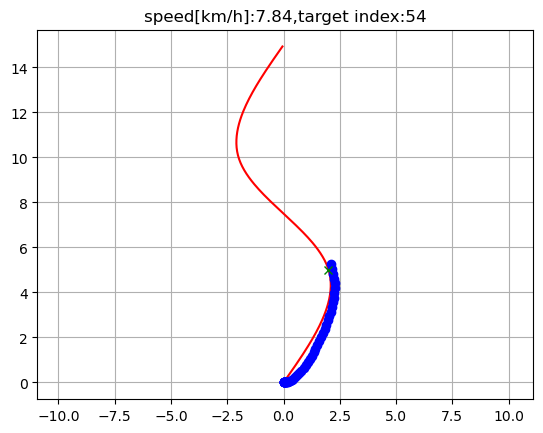

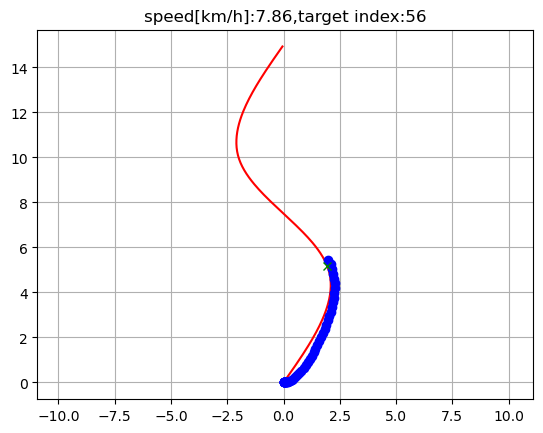

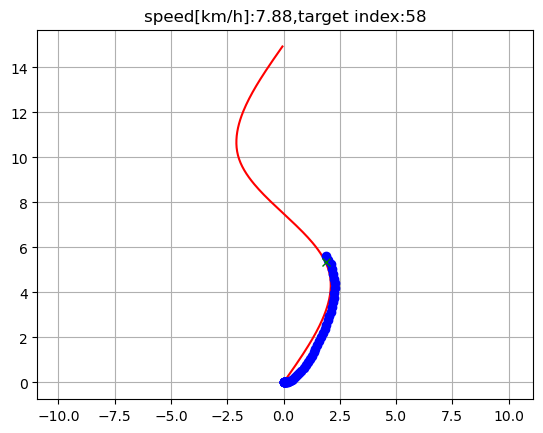

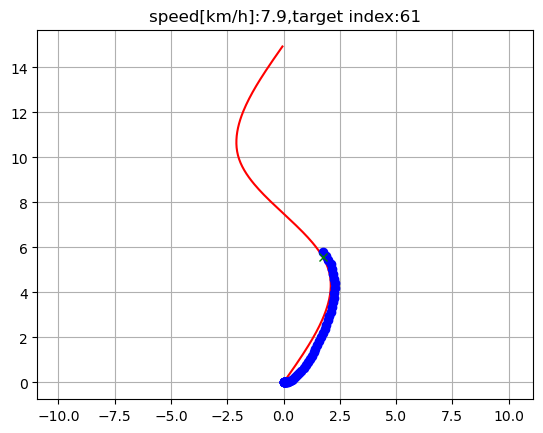

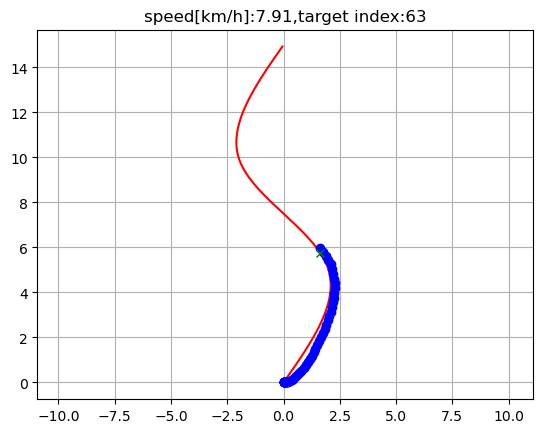

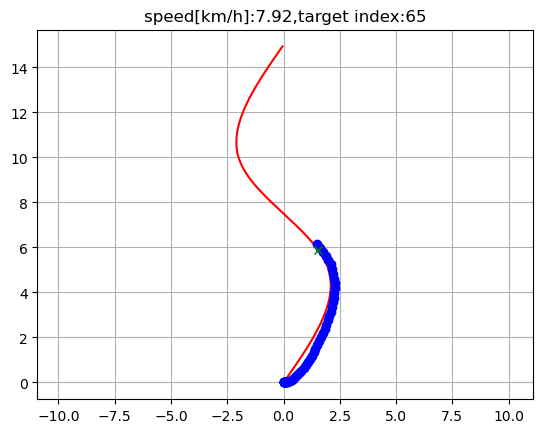

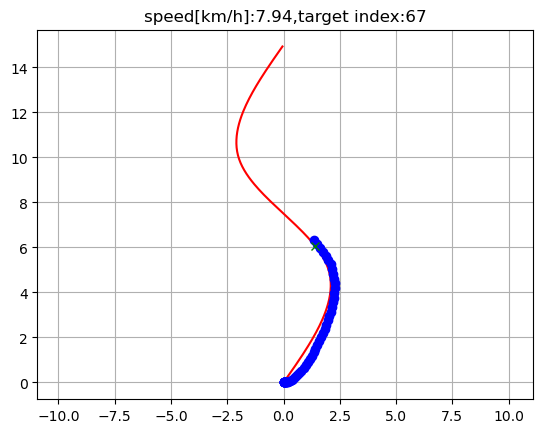

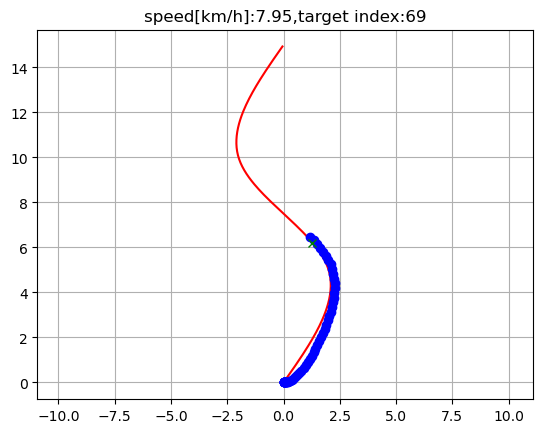

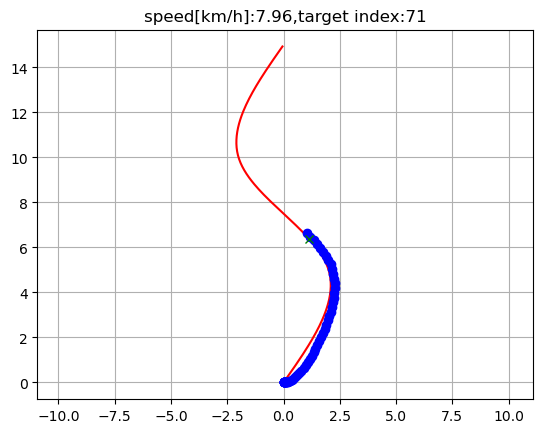

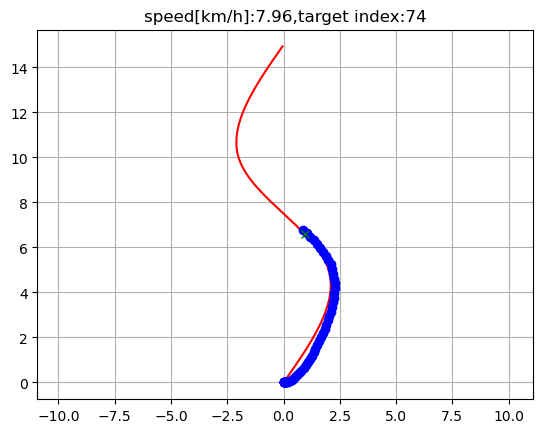

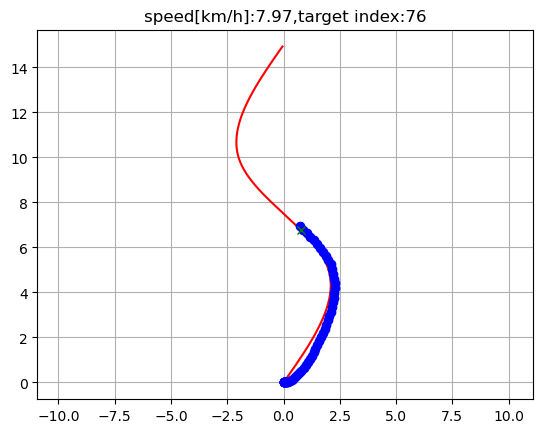

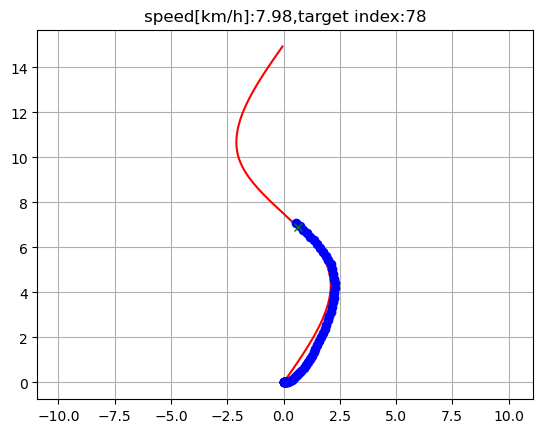

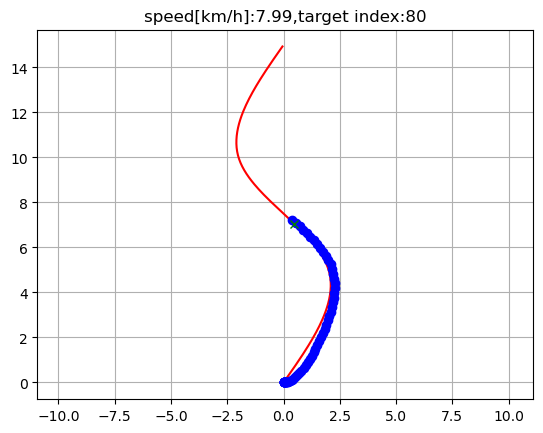

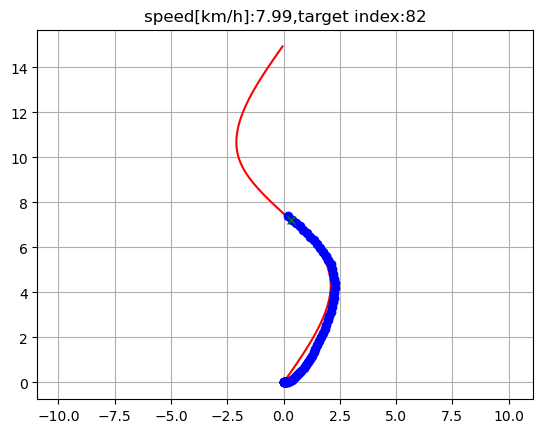

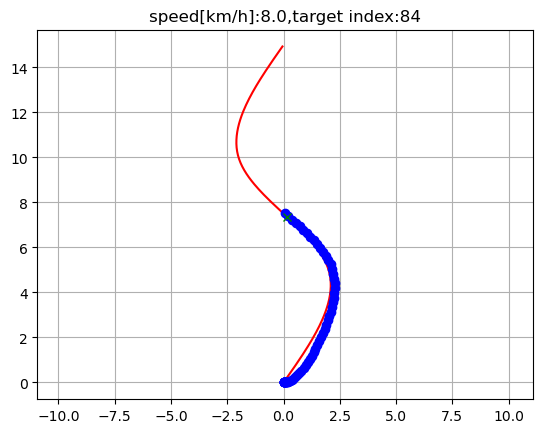

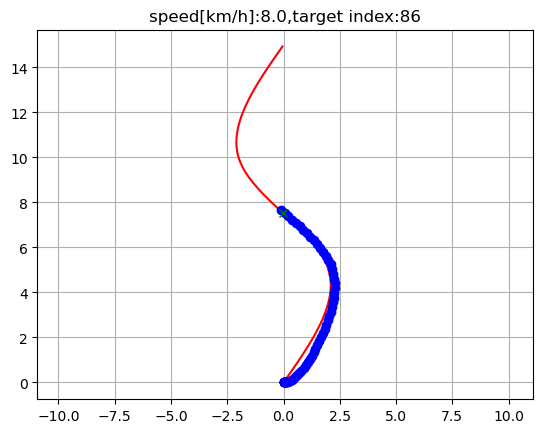

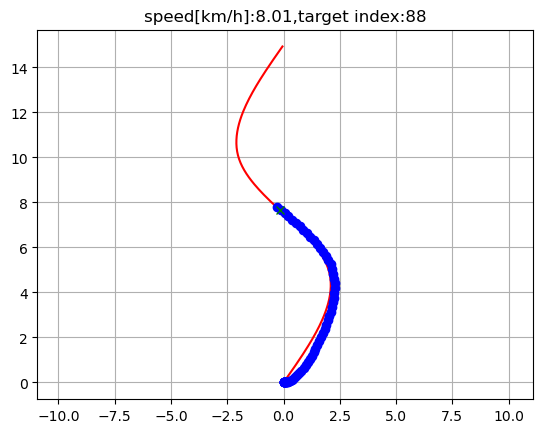

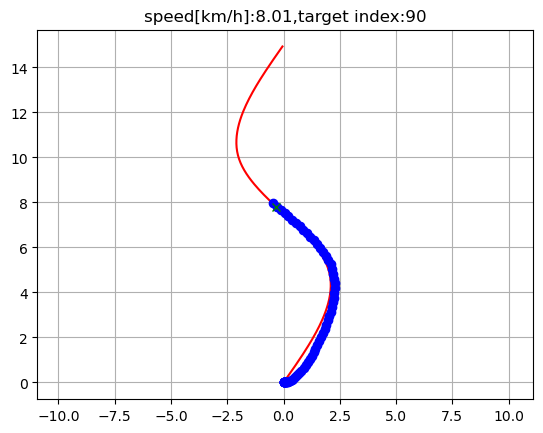

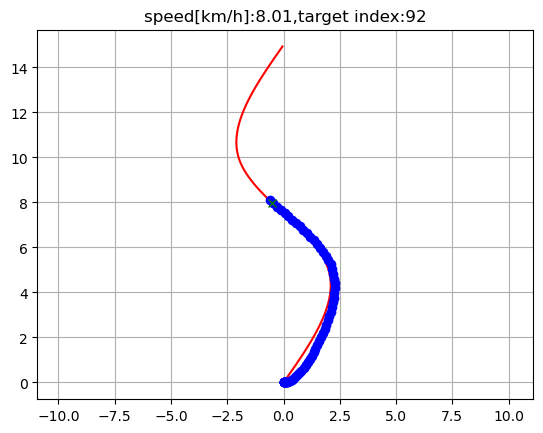

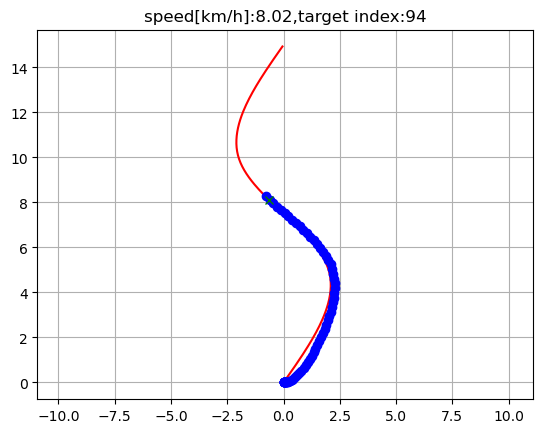

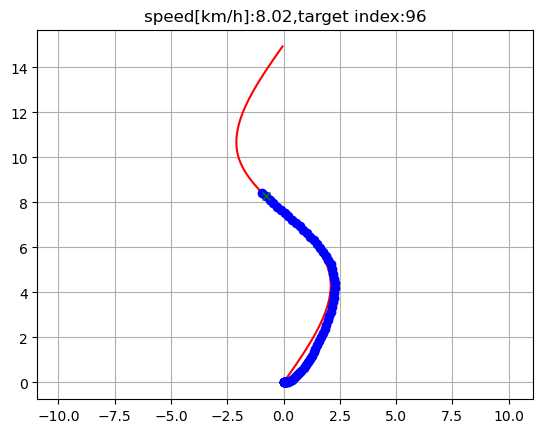

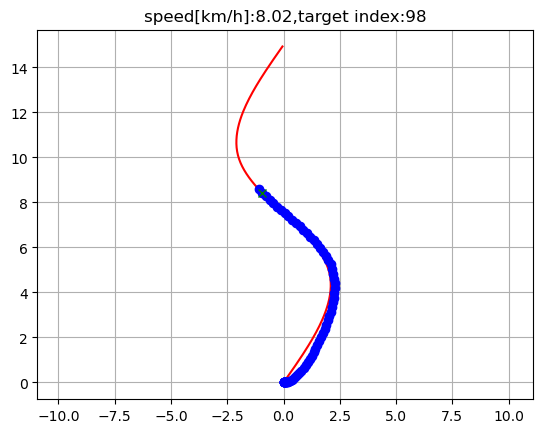

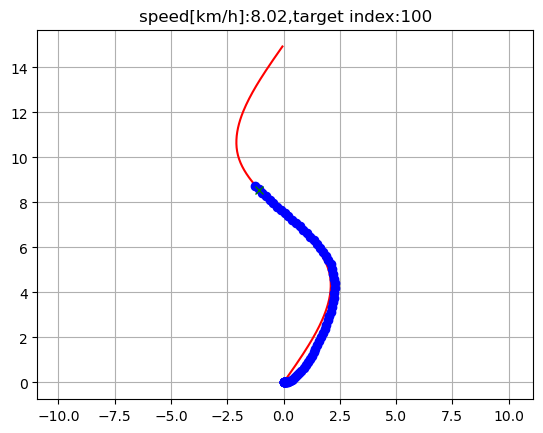

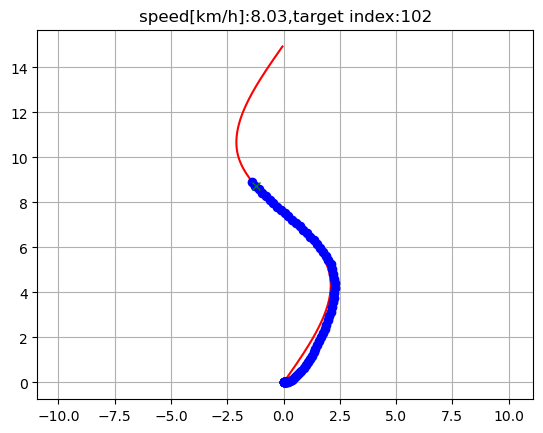

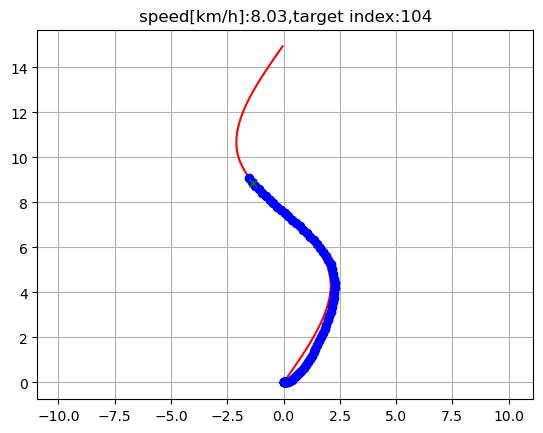

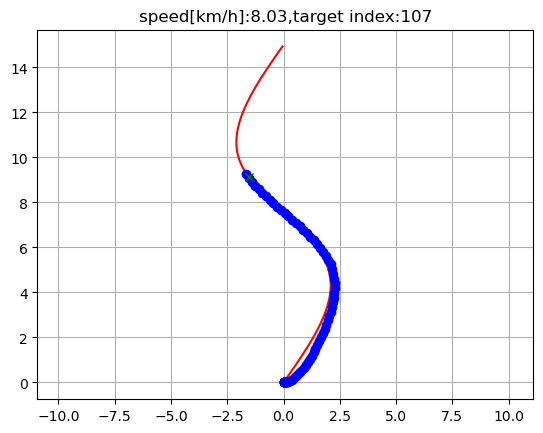

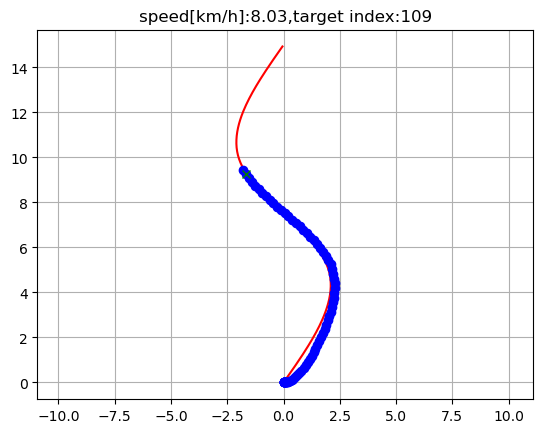

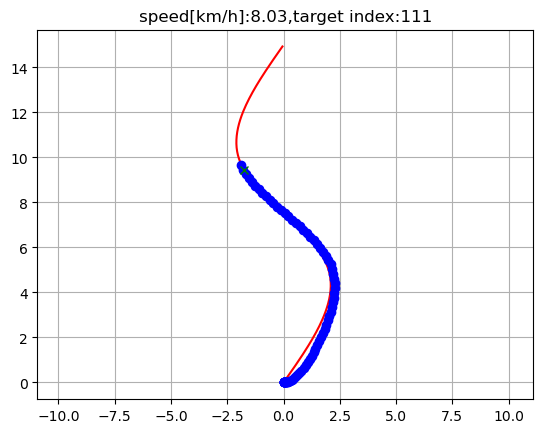

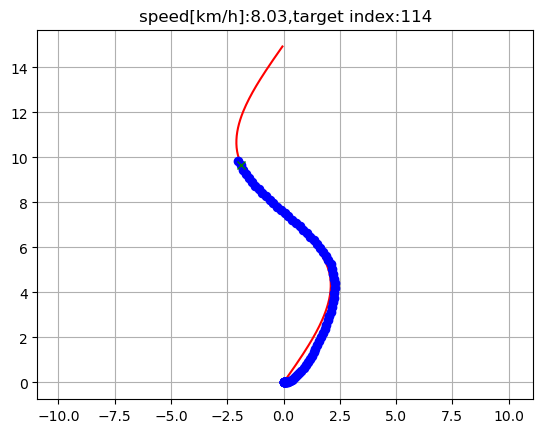

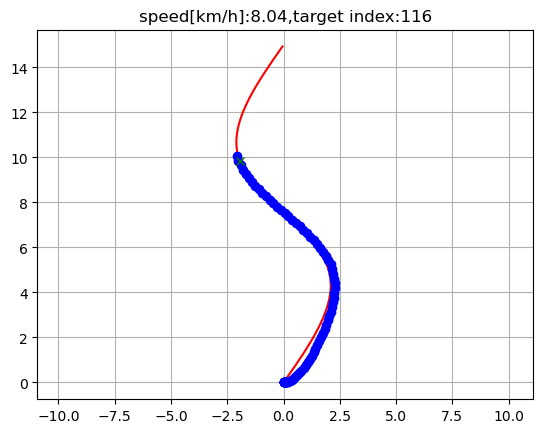

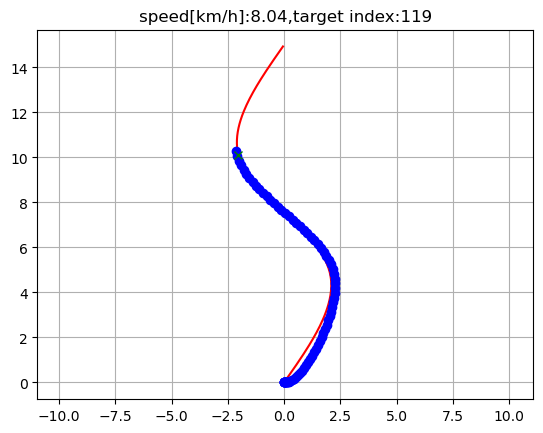

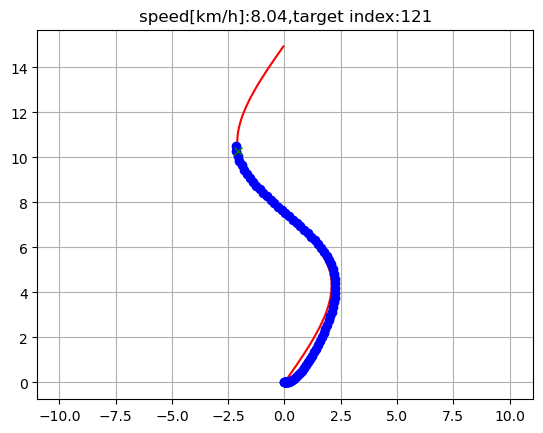

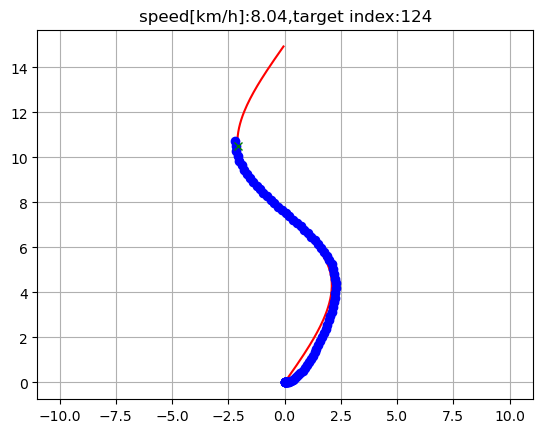

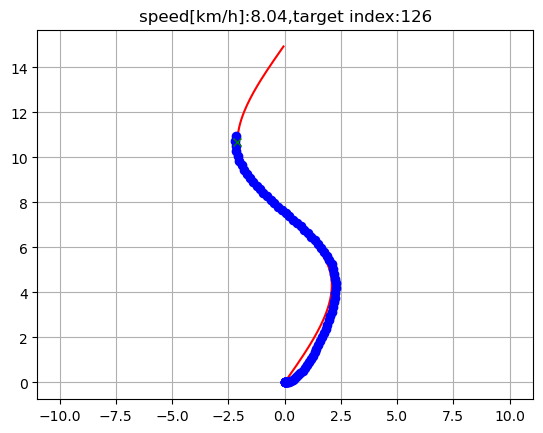

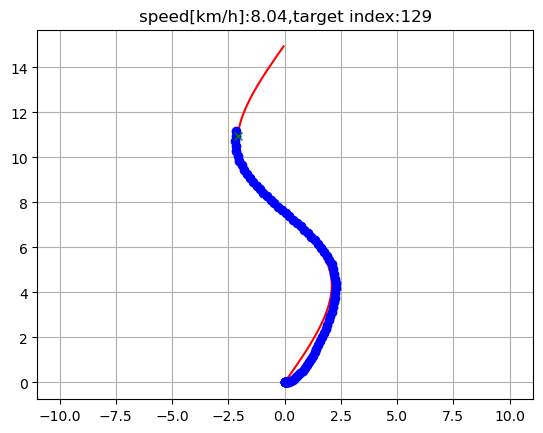

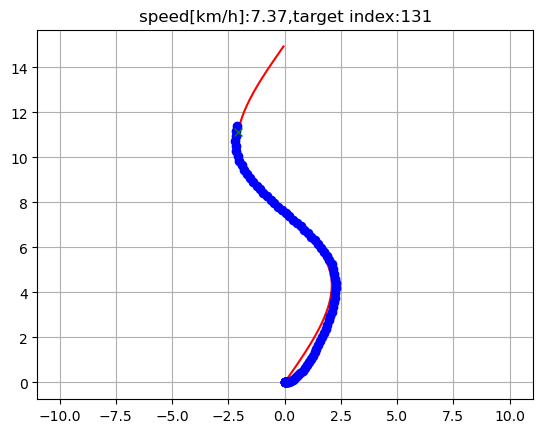

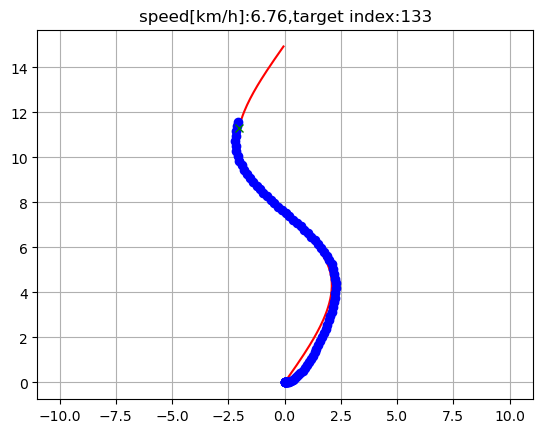

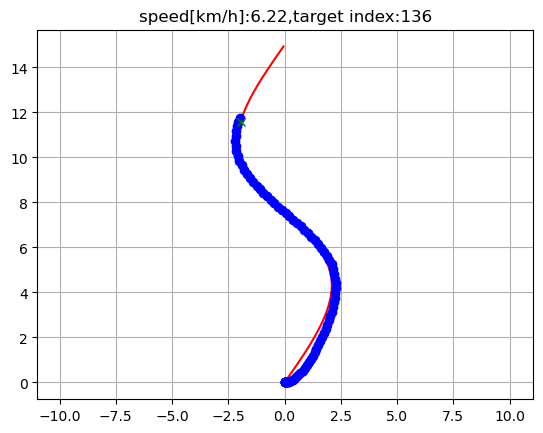

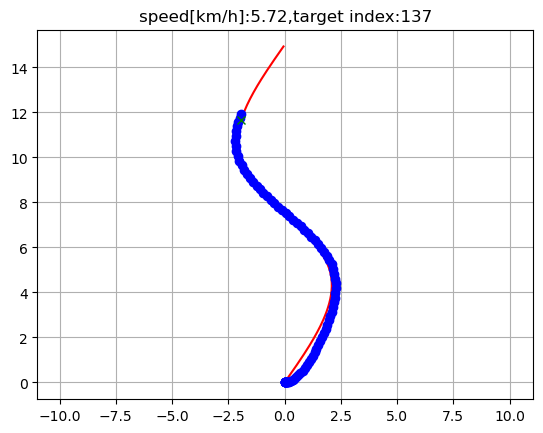

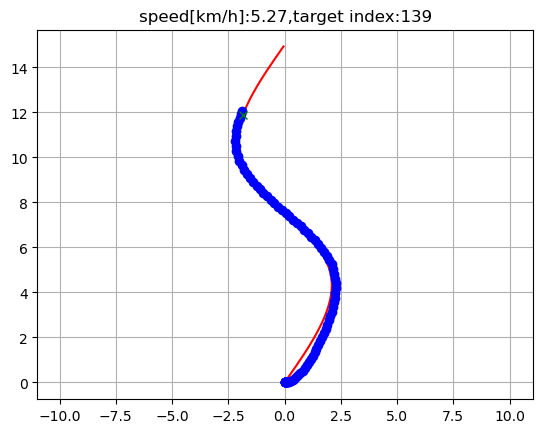

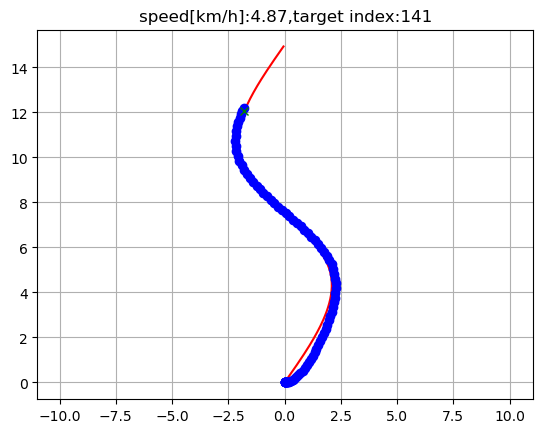

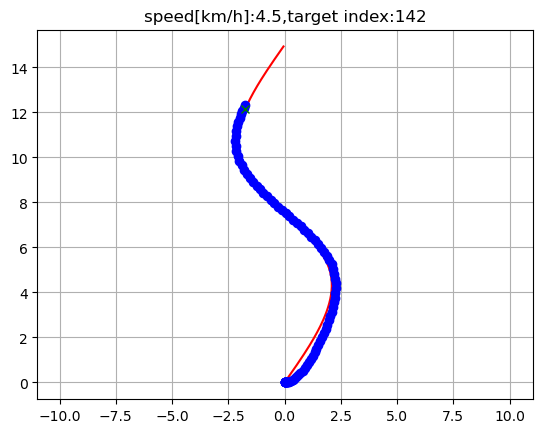

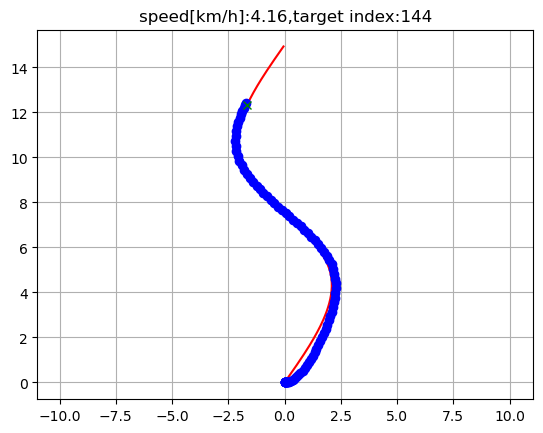

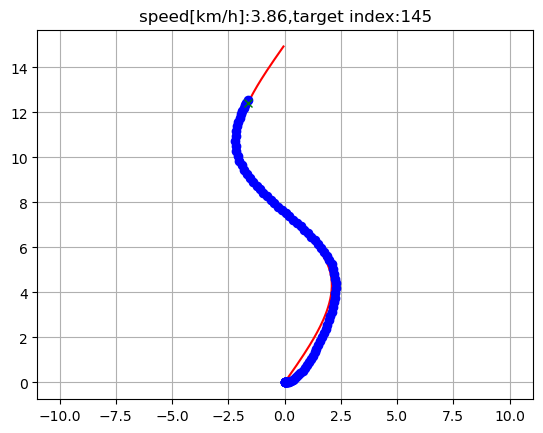

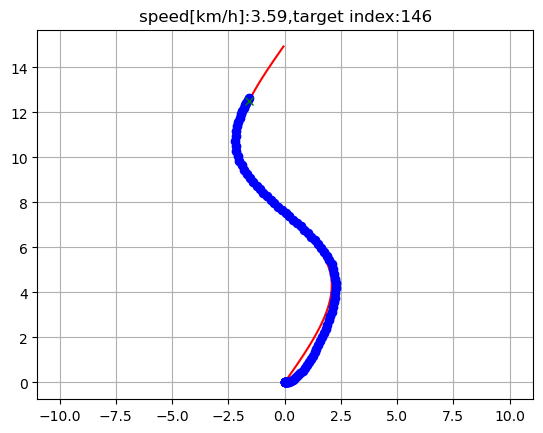

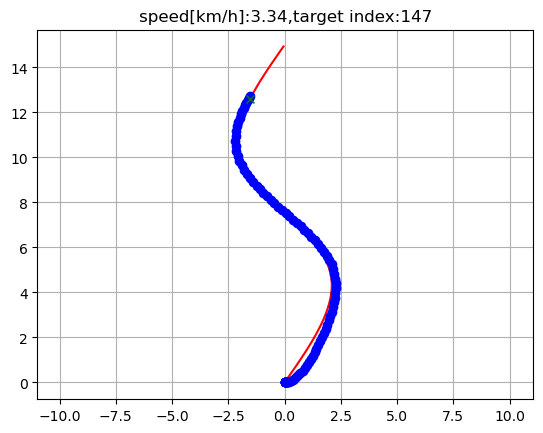

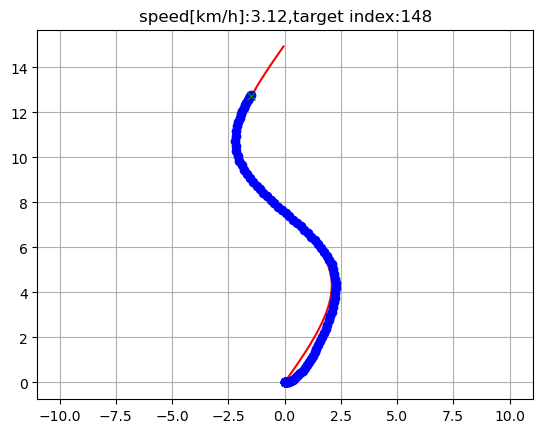

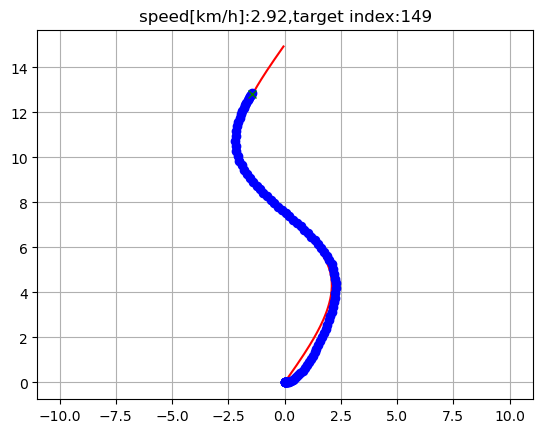

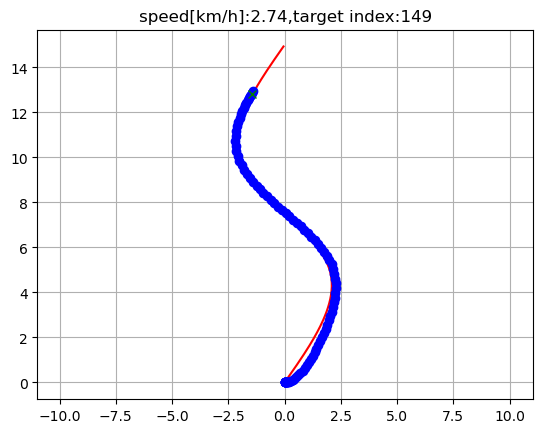

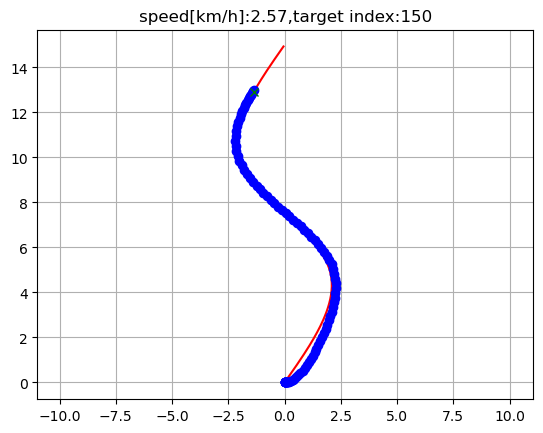

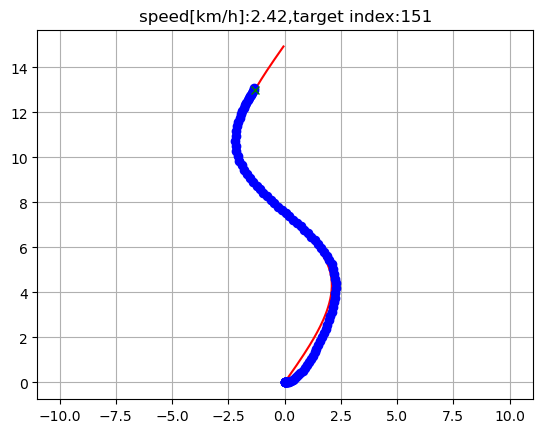

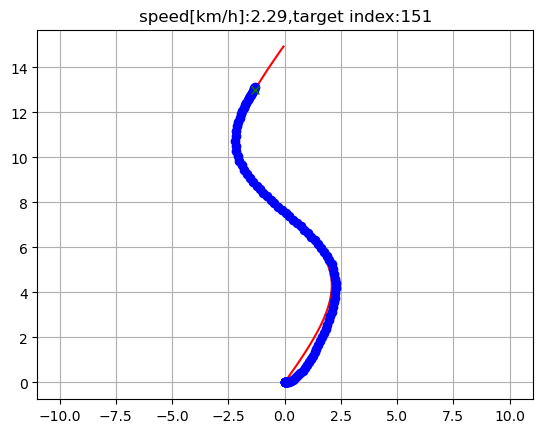

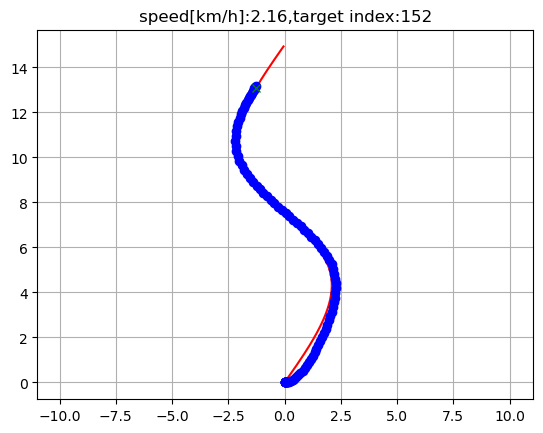

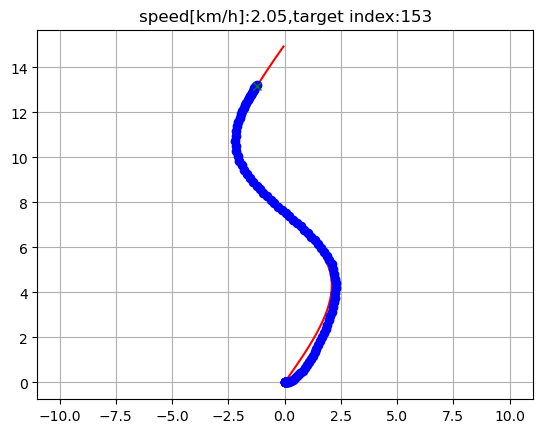

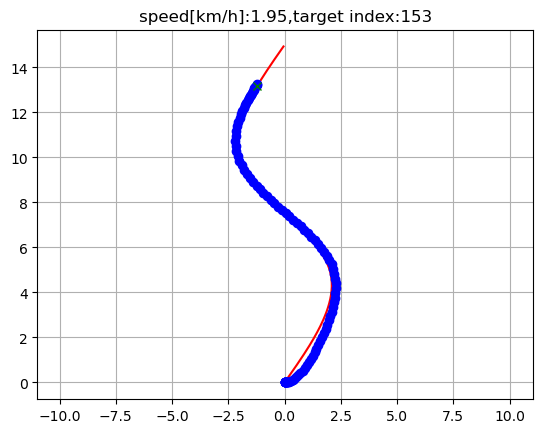

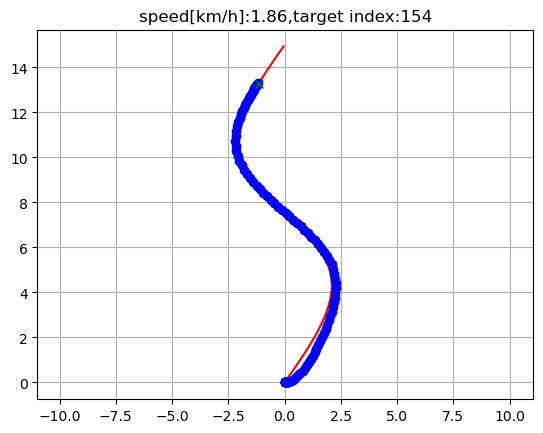

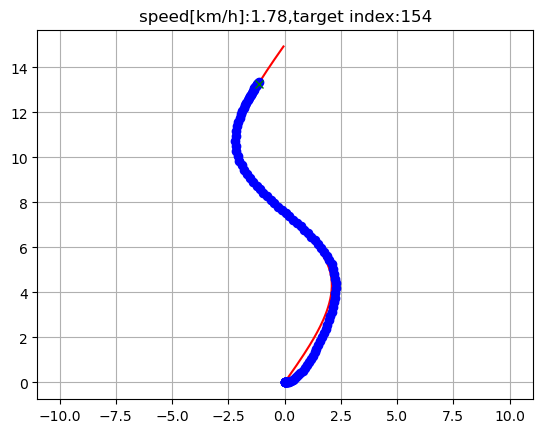

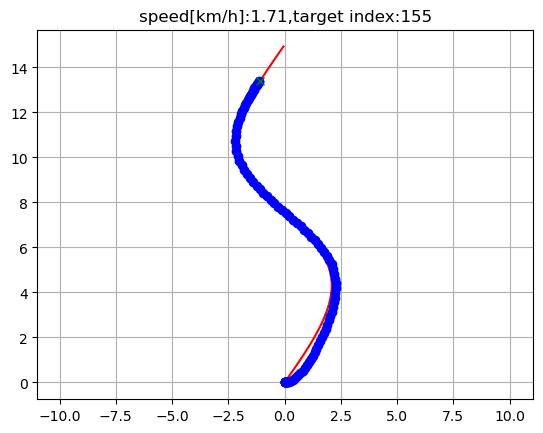

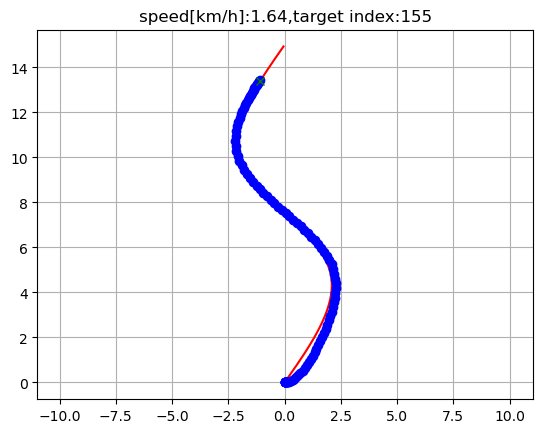

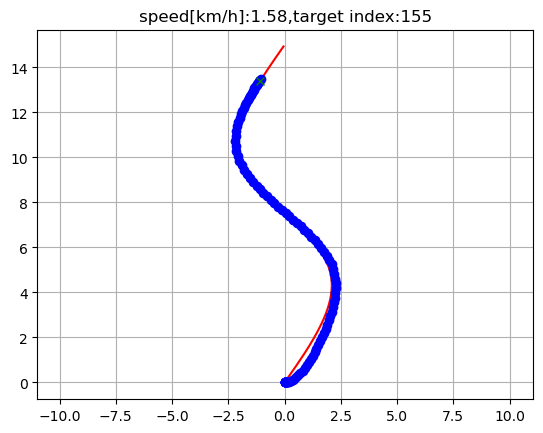

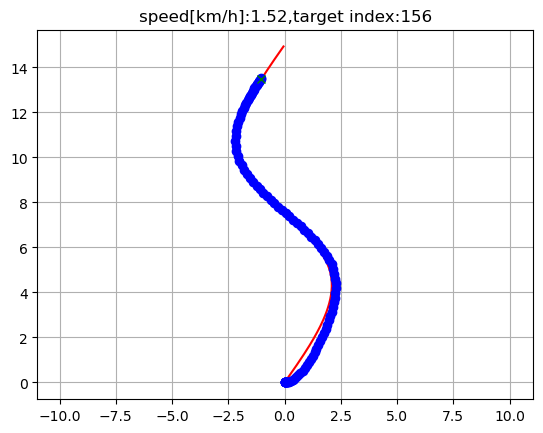

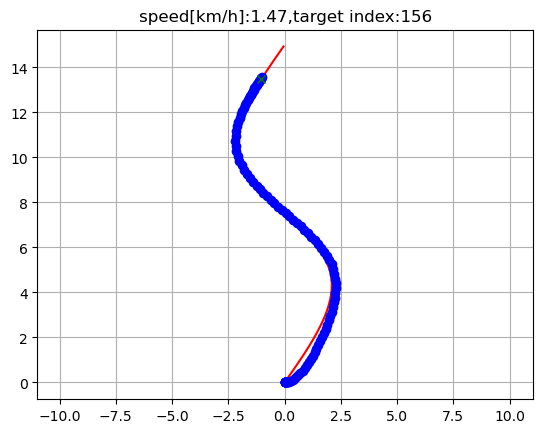

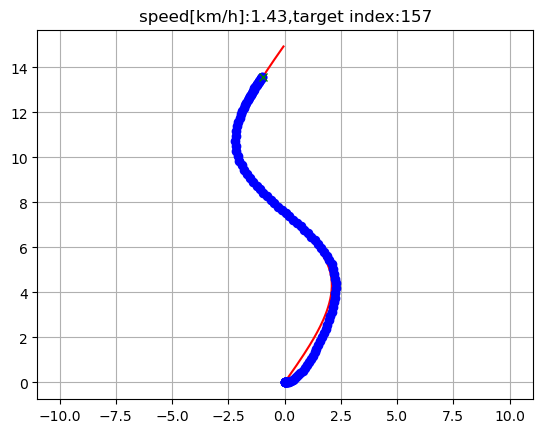

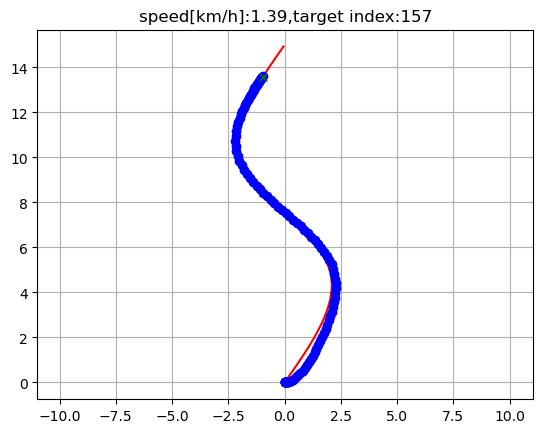

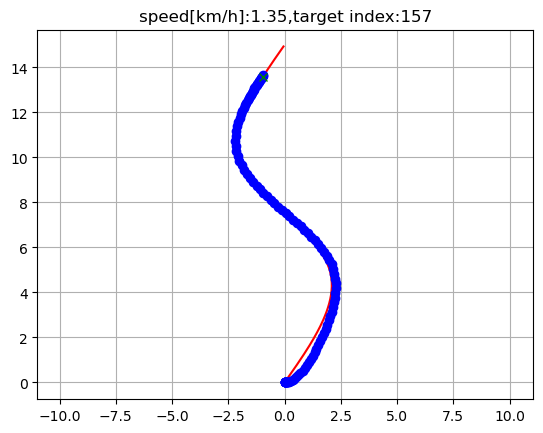

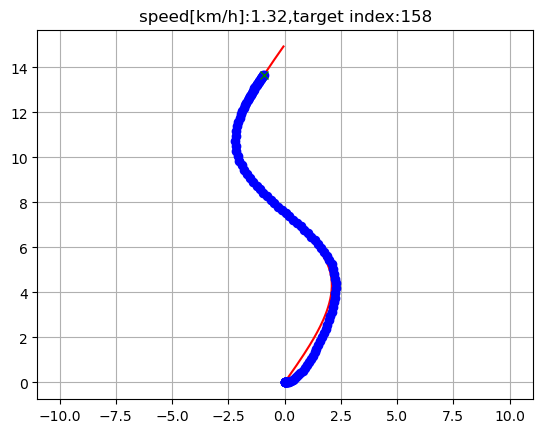

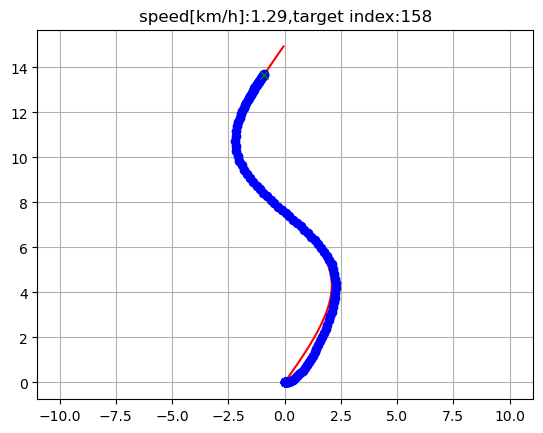

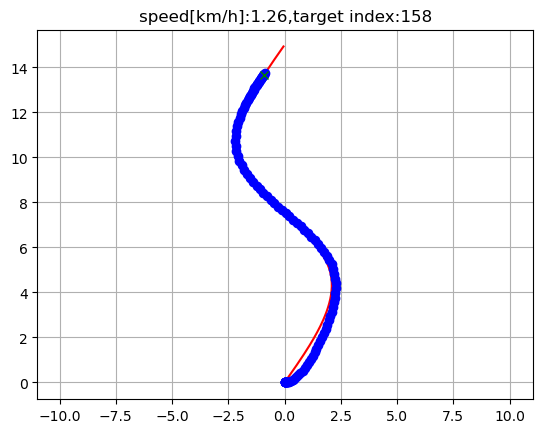

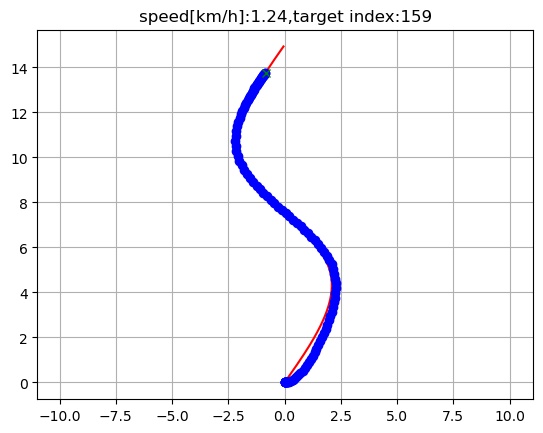

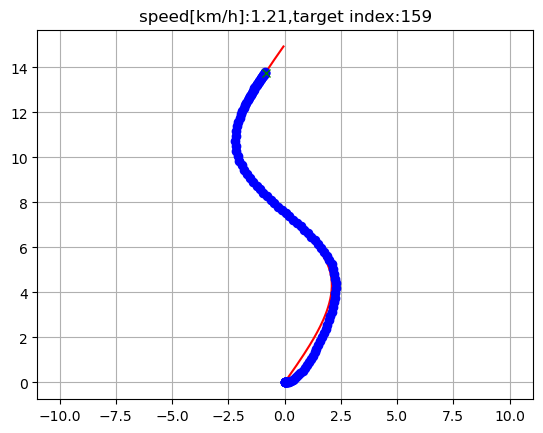

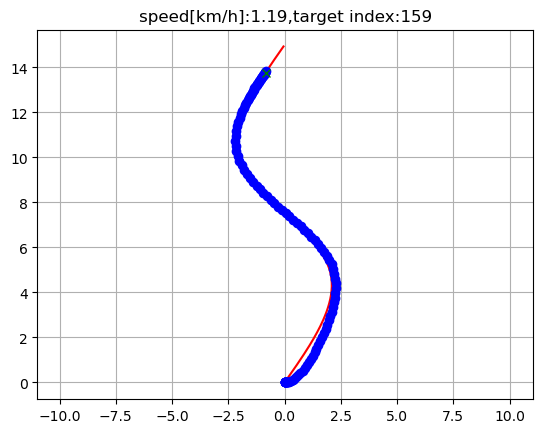

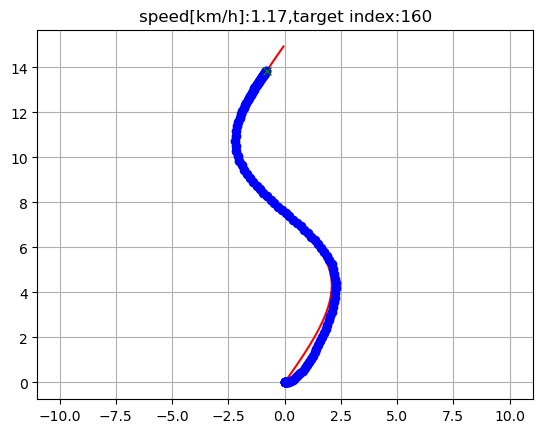

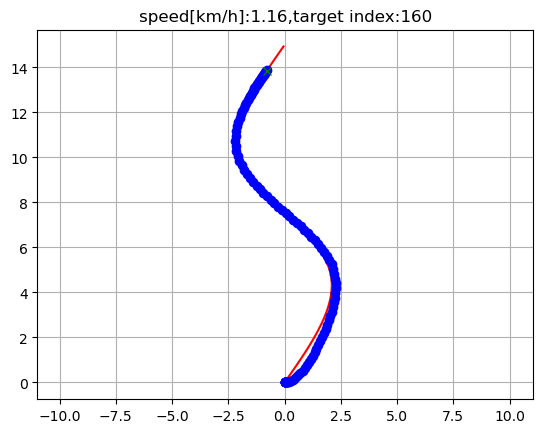

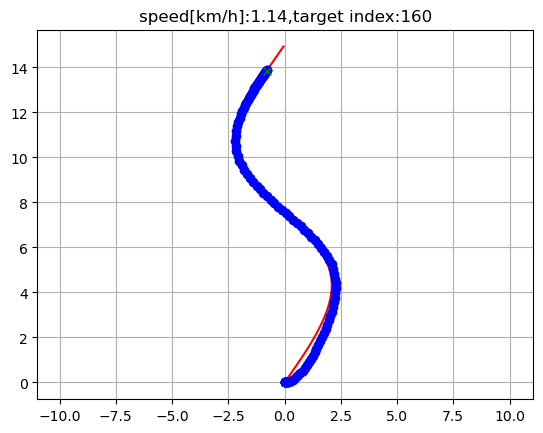

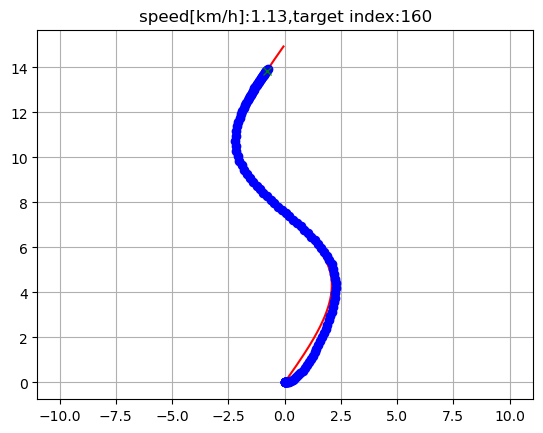

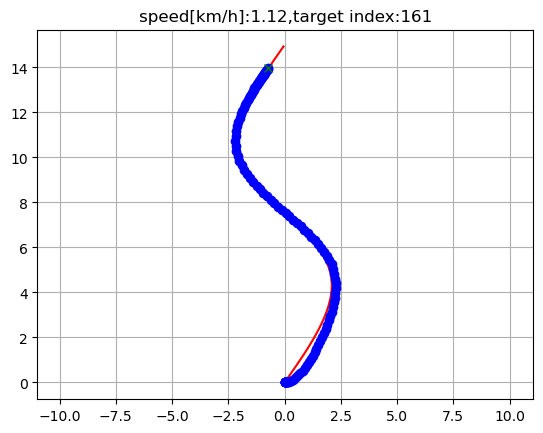

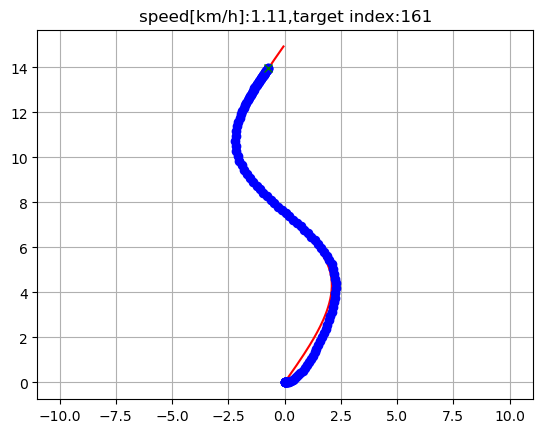

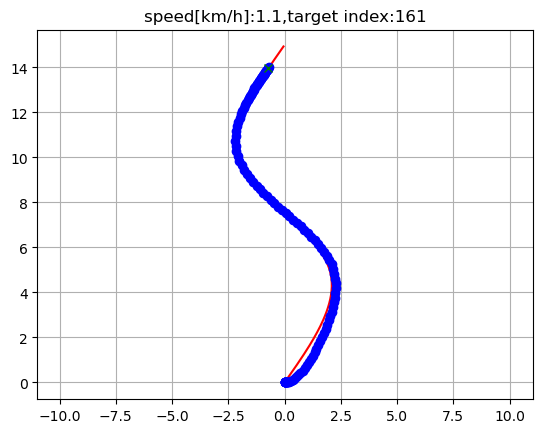

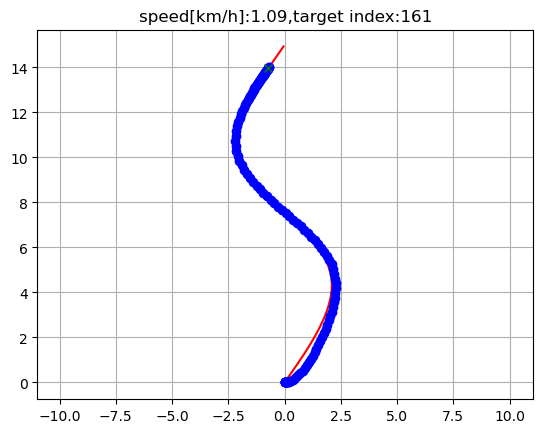

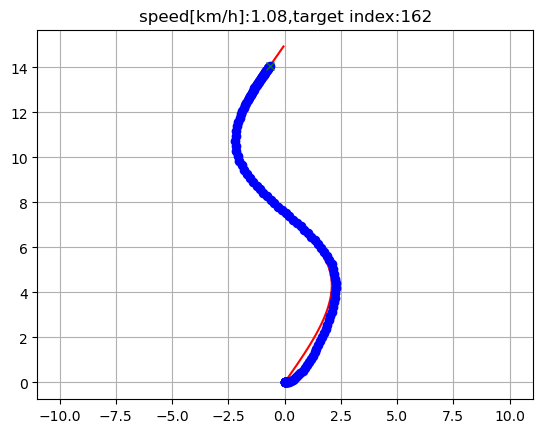

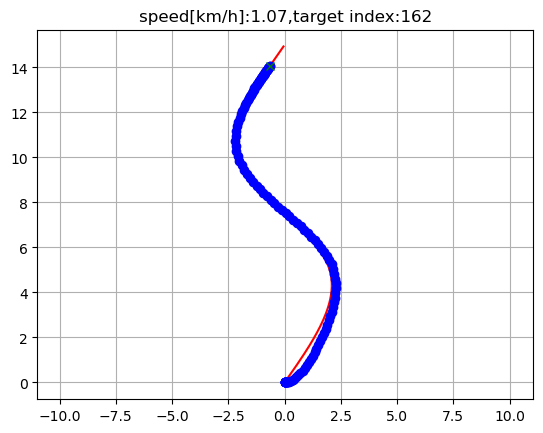

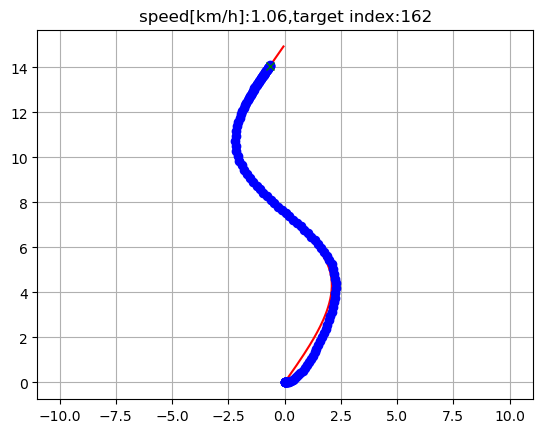

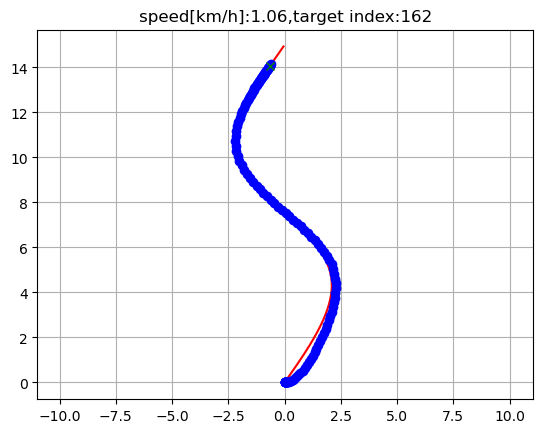

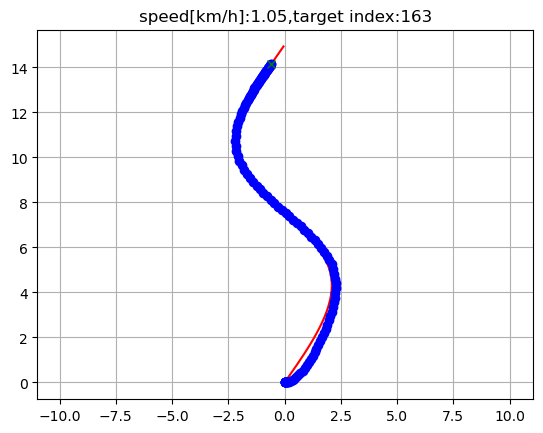

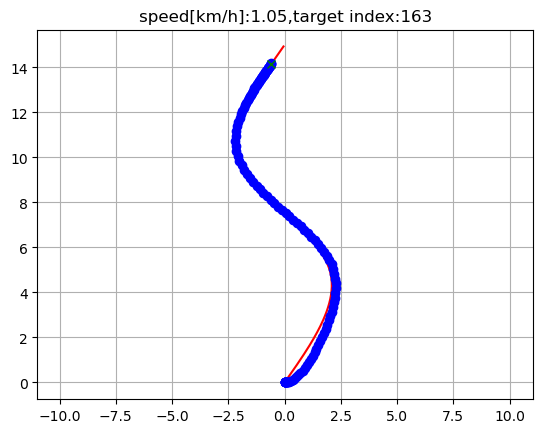

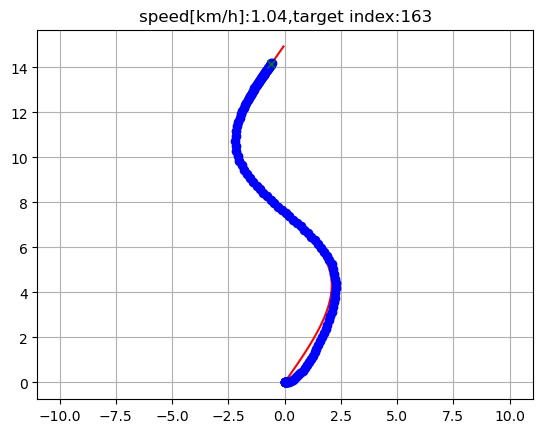

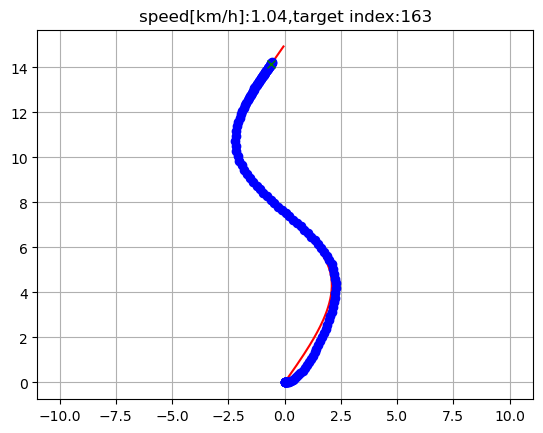

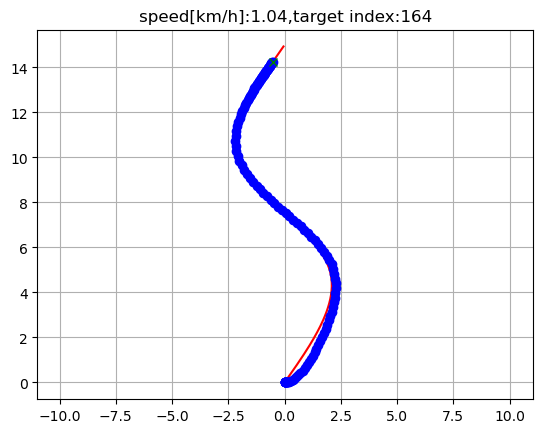

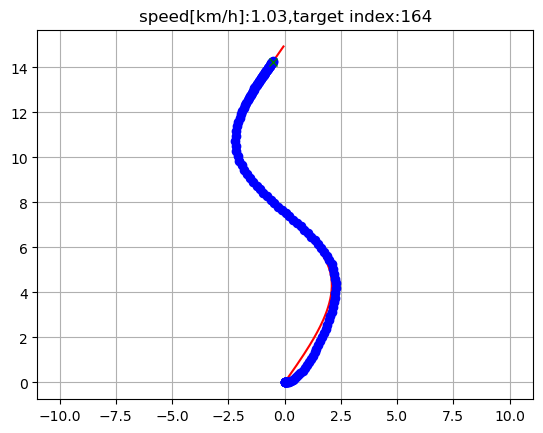

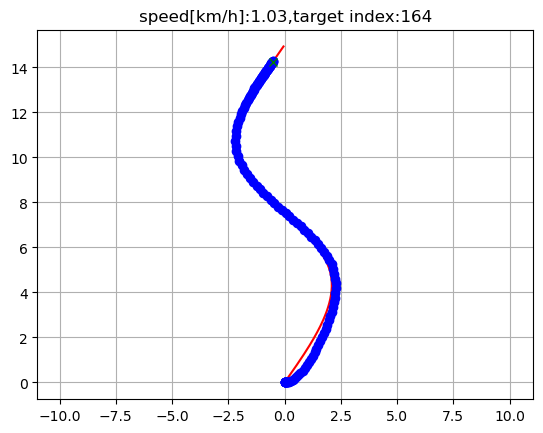

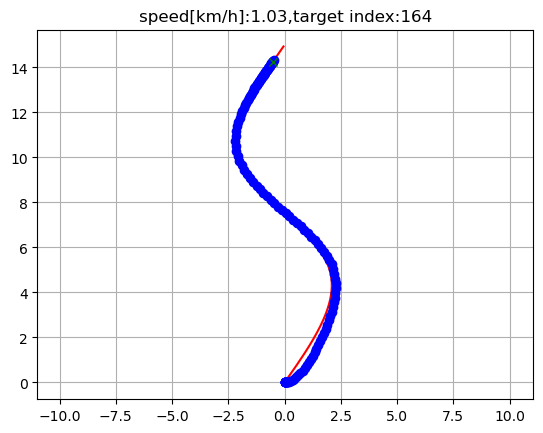

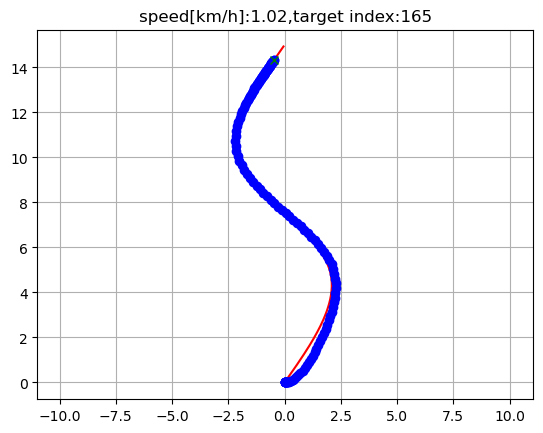

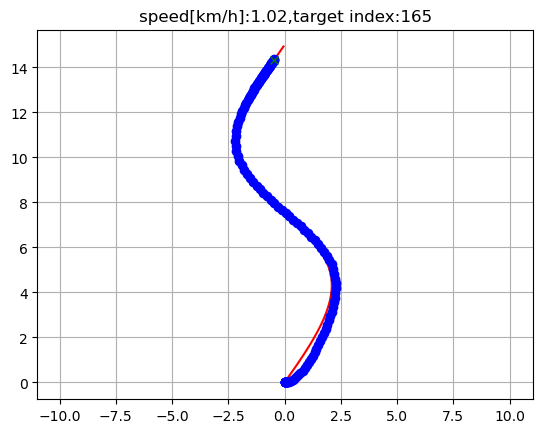

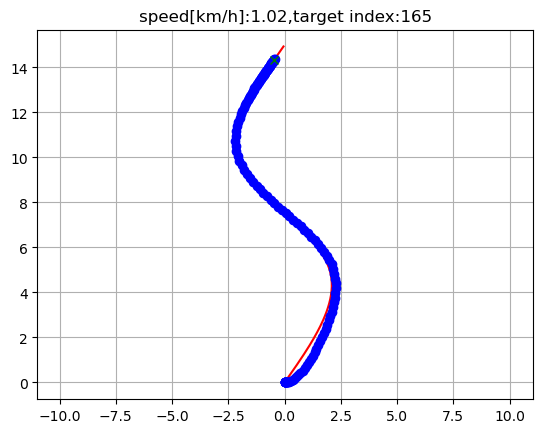

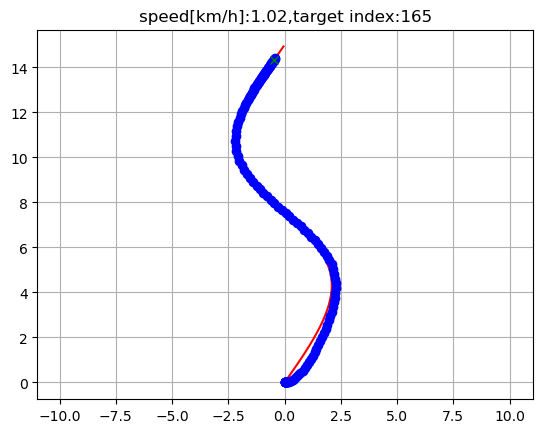

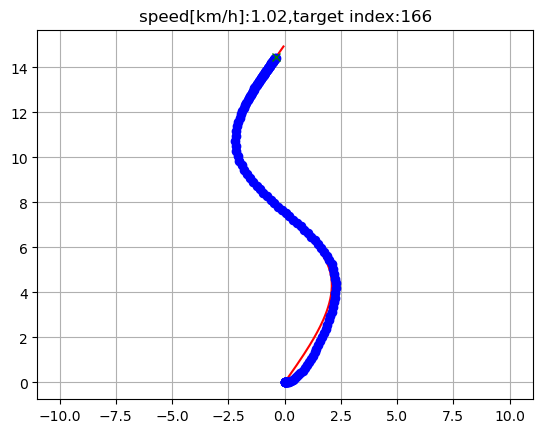

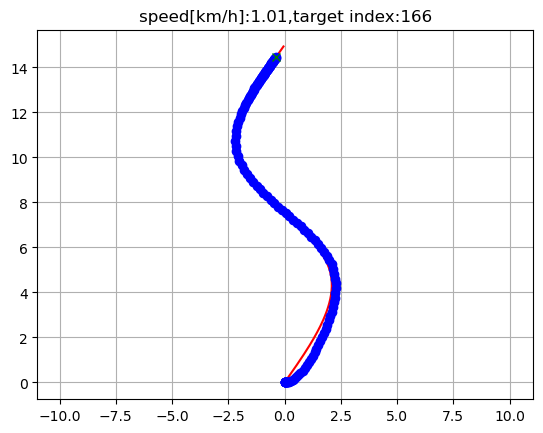

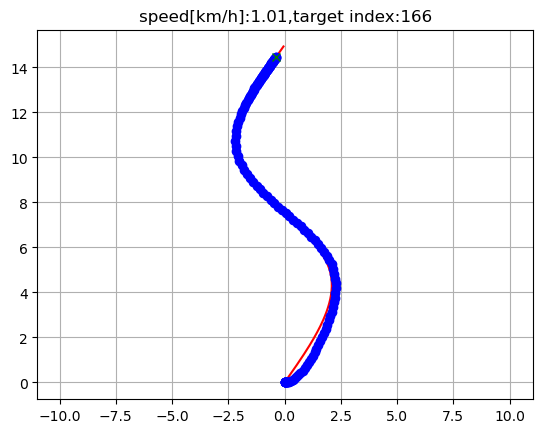

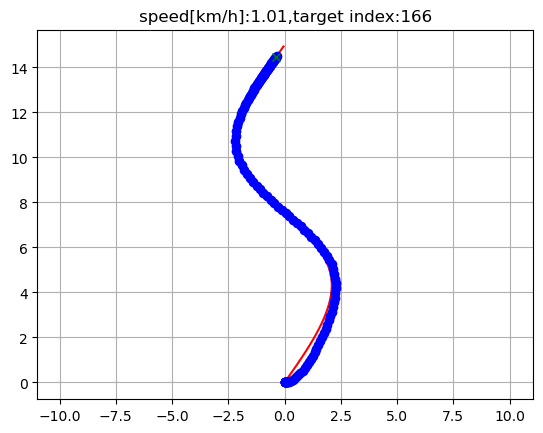

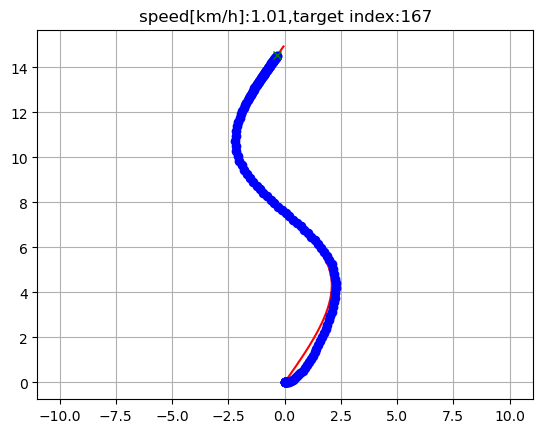

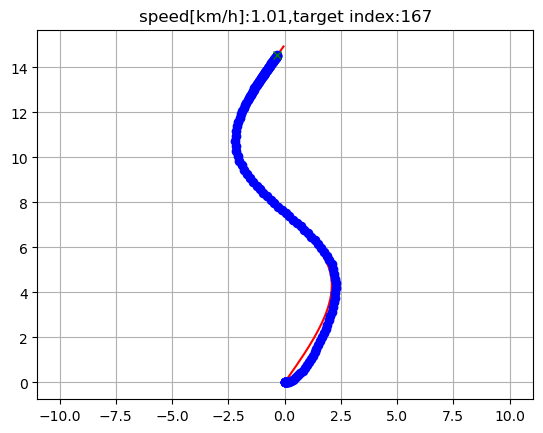

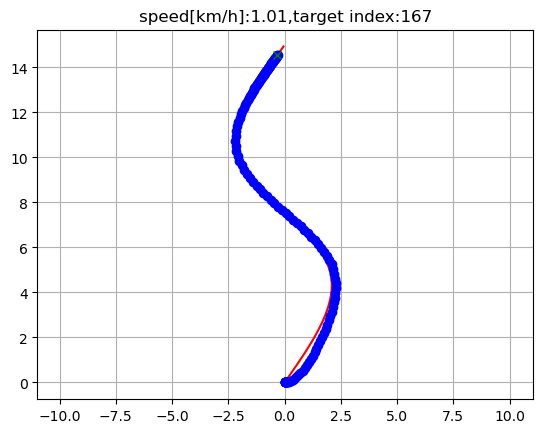

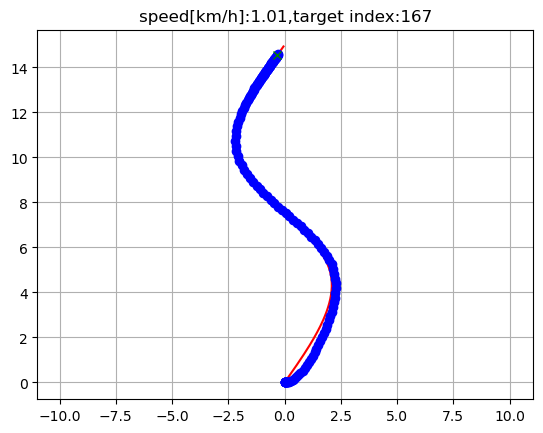

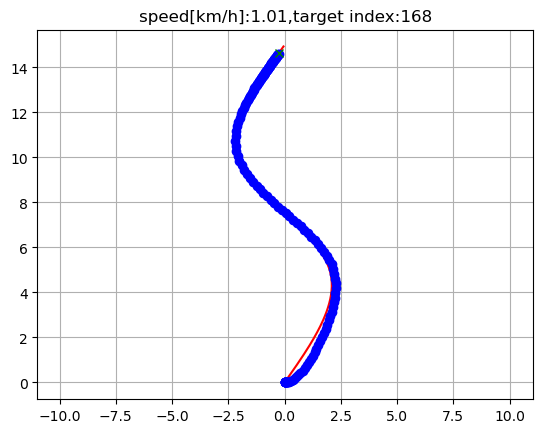

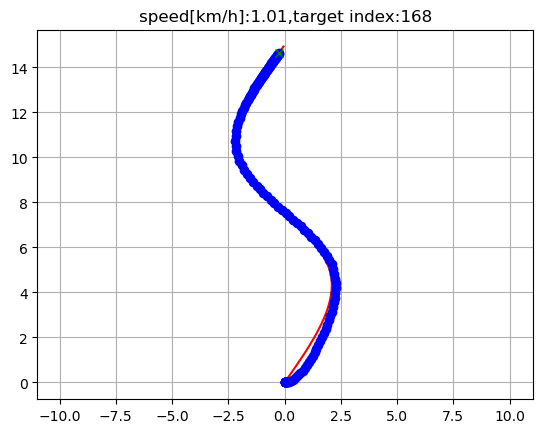

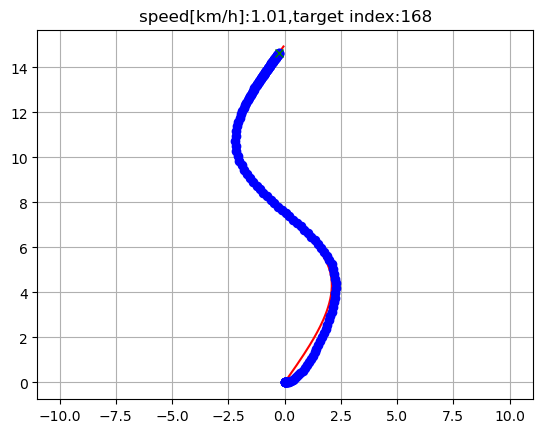

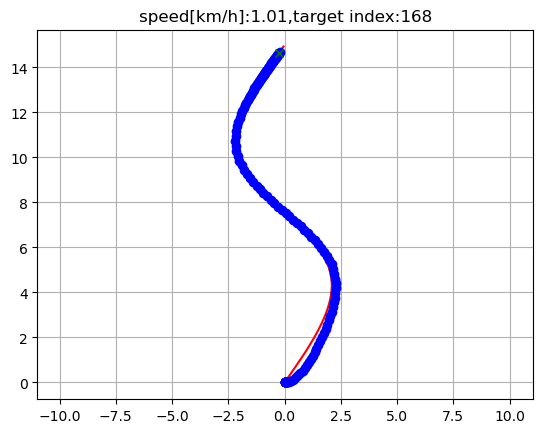

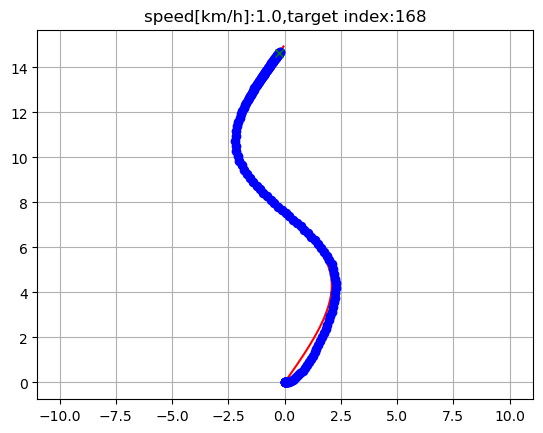

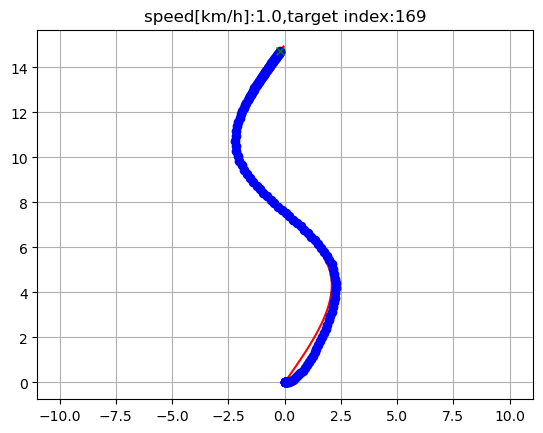

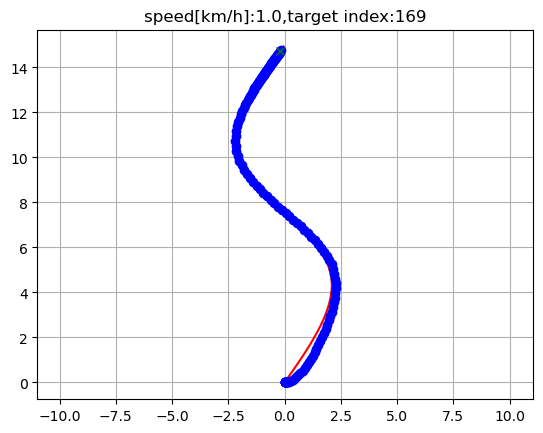

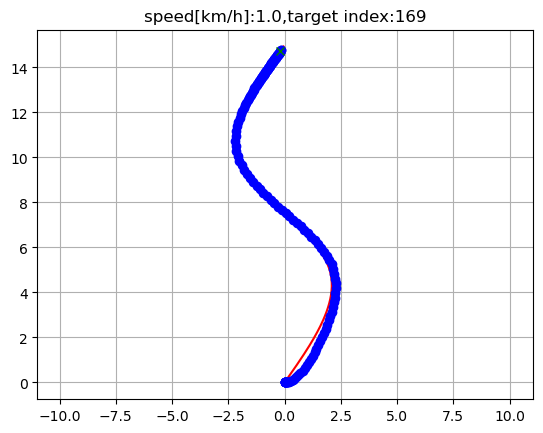

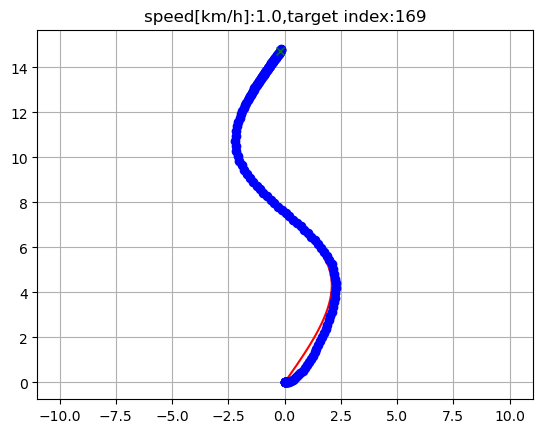

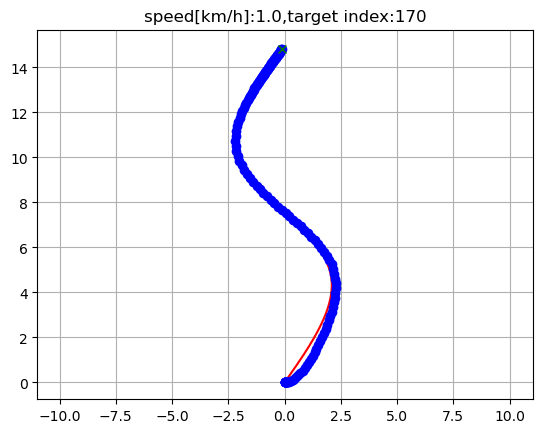

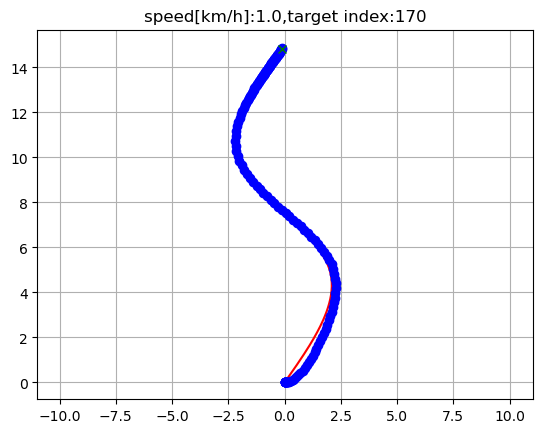

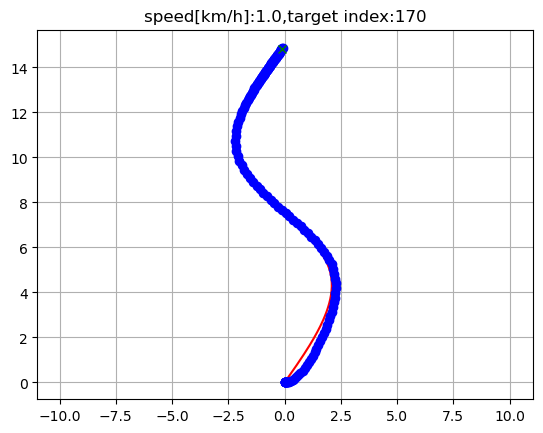

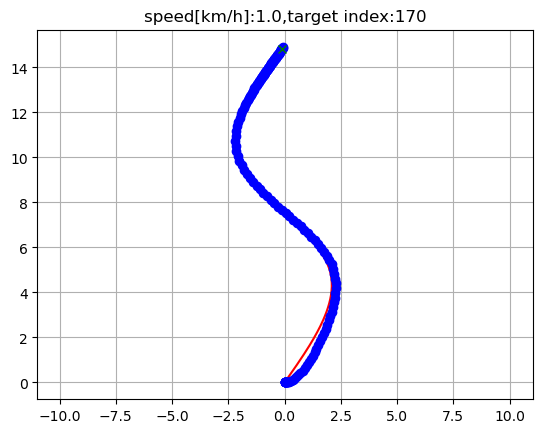

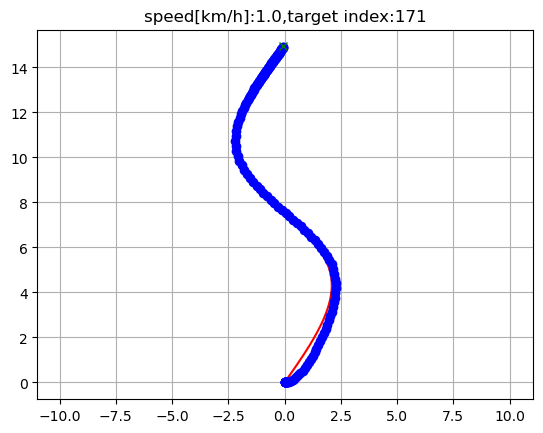

Goal


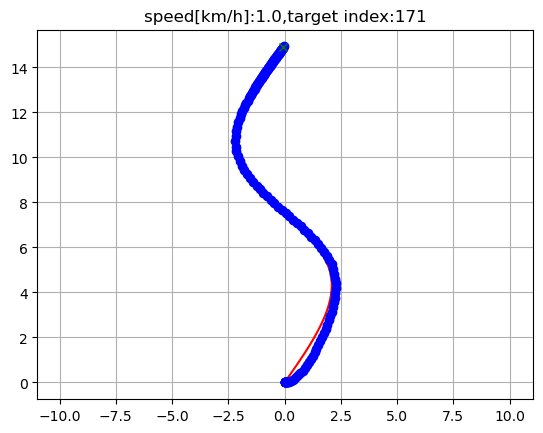

In [9]:
# import matplotlib
# matplotlib.use('MacOSX')

new_state = init_state
new_e = e
new_e_th = e_th
accel = []
steer = []
states = [new_state]
for i in range(len(cx)):
    new_state, new_e, new_e_th, new_accel, new_steer = time_step(new_state, new_e, new_e_th)
    states.append(new_state)
    accel.append(new_accel)
    steer.append(new_steer)
    if math.hypot(new_state.x - goal[0], new_state.y - goal[1]) <= goal_dis:
        break

Text(0, 0.5, 'steering angle[deg]')

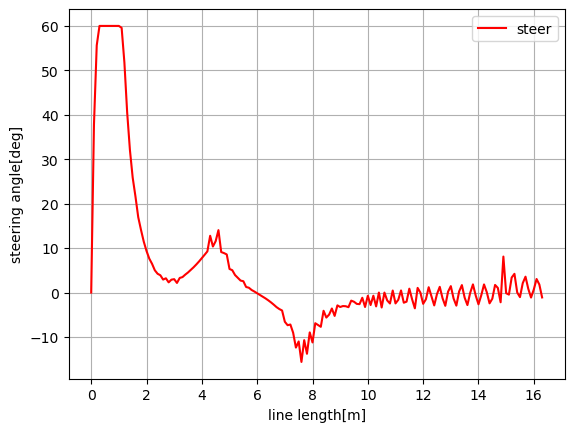

In [10]:
plt.subplots(1)
plt.plot(s[0:164], [np.clip(np.rad2deg(ster_r), -60, 60) for ster_r in steer], "-r", label="steer")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("steering angle[deg]")

In [15]:
accel.insert(0, 0)

Text(0, 0.5, 'acceleration [m/s^2]')

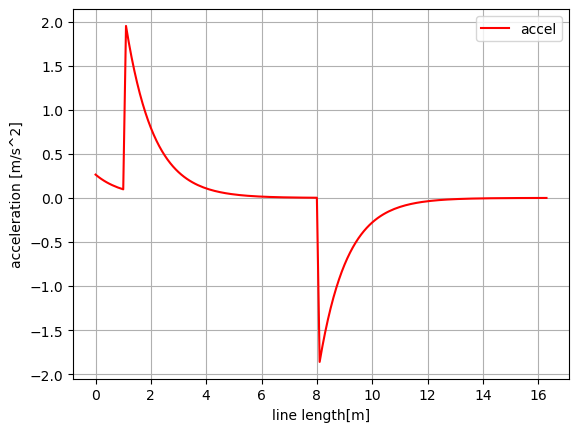

In [17]:
plt.subplots(1)
plt.plot(s[0:164], accel[1:], "-r", label="accel")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("acceleration [m/s^2]")

In [18]:
def reimann(x):
    reimann_sum = []
    for i in range(1, len(accel)):
        reimann_sum.append(np.trapz(accel[:i]) * 0.1 * 2.23)
    return reimann_sum

In [22]:
len(accel)

165

In [23]:
len(reimann(accel))

164

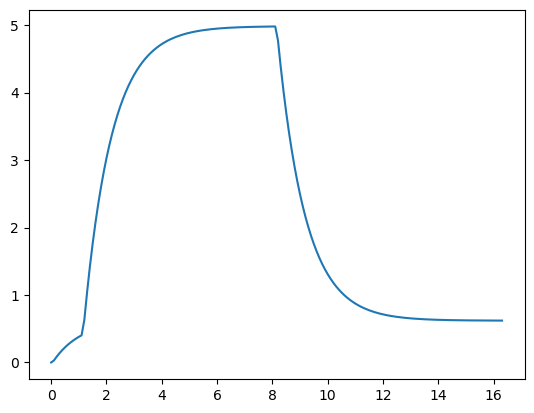

In [20]:
plt.plot(s[0:164], reimann(accel))